In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from pathlib import Path
from typing import Any
from logging import INFO, DEBUG
import json
import os
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from flwr.common import log, ndarrays_to_parameters
import matplotlib.pyplot as plt
import math

from src.common.client_utils import (
    load_femnist_dataset,
    get_network_generator_cnn as get_network_generator,
    get_device,
    get_model_parameters,
    aggregate_weighted_average,
)


from src.flwr_core import (
    set_all_seeds,
    get_paths,
    decompress_dataset,
    get_flower_client_generator,
    sample_random_clients,
    get_federated_evaluation_function,
)

from src.estimate import (
    compute_critical_batch,
)

from src.experiments_simulation import (
    run_simulation,
    centralized_experiment,
)

from src.utils import get_centralized_acc_from_hist

PathType = Path | str | None

**Global variables**

In [2]:
set_all_seeds()

PATHS = get_paths()

HOME_DIR = PATHS["home_dir"]
DATASET_DIR = PATHS["dataset_dir"]
DATA_DIR = PATHS["data_dir"]
CENTRALIZED_PARTITION = PATHS["centralized_partition"]
CENTRALIZED_MAPPING = PATHS["centralized_mapping"]
FEDERATED_PARTITION = PATHS["federated_partition"]

# extract dataset from tar.gz
decompress_dataset(PATHS)

In [3]:
NETWORK_GENERATOR = get_network_generator()
SEED_NET = NETWORK_GENERATOR()
SEED_MODEL_PARAMS = get_model_parameters(SEED_NET)
CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION)

In [4]:
# Centralized experiments
centralized_experiment_batch_sizes = [32, 64, 128, 256, 512, 1024]

# Load the centralized dataset using the same function as in FL.
# The centralized mapping folder should be the one used in the FL centralized experiment.
centralized_train_dataset = load_femnist_dataset(data_dir=DATA_DIR,mapping=CENTRALIZED_MAPPING, name="train")
centralized_test_dataset = load_femnist_dataset(data_dir=DATA_DIR, mapping=CENTRALIZED_MAPPING, name="test")

centralized_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0,
    "num_workers": 0,
    "max_batches": 100,
}

centralized_test_config = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
    "target_accuracy": 0.60,
}

In [5]:
# FL experiments
experiment_batch_sizes = [16, 32, 64, 128, 256]
cohort_sizes = [5, 10, 20, 50, 75, 100]


# Federated configuration dictionary
federated_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0,
    "num_workers": 0,
    #"max_batches": 100,
}

federated_test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

num_rounds = 10
num_total_clients = 100
num_evaluate_clients = 0
num_clients_per_round = 10

initial_parameters = ndarrays_to_parameters(SEED_MODEL_PARAMS)

federated_evaluation_function = get_federated_evaluation_function(
    batch_size=federated_test_config["batch_size"],
    num_workers=federated_test_config["num_workers"],
    model_generator=NETWORK_GENERATOR,
    criterion=nn.CrossEntropyLoss(),
    max_batches=None if "max_batches" not in federated_test_config else federated_test_config["max_batches"],
)

server_learning_rate = 1.0
server_momentum = 0.0
accept_failures = False


CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION)

list_of_ids = sample_random_clients(
    num_total_clients, federated_train_config["batch_size"],
    CID_CLIENT_GENERATOR,
)

federated_client_generator = (
    get_flower_client_generator(
        NETWORK_GENERATOR, FEDERATED_PARTITION, lambda seq_id: list_of_ids[seq_id]
    )
)

INFO flwr 2025-02-28 18:31:48,735 | flwr_core.py:105 | cid: 2530
INFO flwr 2025-02-28 18:31:49,053 | flwr_core.py:105 | cid: 2184
INFO flwr 2025-02-28 18:31:49,055 | flwr_core.py:105 | cid: 2907
INFO flwr 2025-02-28 18:31:49,056 | flwr_core.py:105 | cid: 1498
INFO flwr 2025-02-28 18:31:49,057 | flwr_core.py:105 | cid: 2338
INFO flwr 2025-02-28 18:31:49,058 | flwr_core.py:105 | cid: 2399
INFO flwr 2025-02-28 18:31:49,060 | flwr_core.py:105 | cid: 2997
INFO flwr 2025-02-28 18:31:49,061 | flwr_core.py:105 | cid: 678
INFO flwr 2025-02-28 18:31:49,062 | flwr_core.py:105 | cid: 3175
INFO flwr 2025-02-28 18:31:49,063 | flwr_core.py:105 | cid: 1363
INFO flwr 2025-02-28 18:31:49,064 | flwr_core.py:105 | cid: 1571
INFO flwr 2025-02-28 18:31:49,065 | flwr_core.py:105 | cid: 2600
INFO flwr 2025-02-28 18:31:49,066 | flwr_core.py:105 | cid: 1473
INFO flwr 2025-02-28 18:31:49,067 | flwr_core.py:105 | cid: 1260
INFO flwr 2025-02-28 18:31:49,068 | flwr_core.py:105 | cid: 1603
INFO flwr 2025-02-28 18:31

## **Experiments**

### LR scaling

Some rules usually are:

**Linear scaling**

$$ \text{LR} \propto \text{batch size} $$

so, starting with 0.1 at 256, we get then, 0.05 at 128, 0.025 at 64, 0.0125 at 32, 0.00625 at 16.

However, this is not always the case, and it depends on the model, the dataset, the optimizer, etc.

We can also use:

**Sqrt scaling**

$$ \text{LR} \propto \sqrt{\text{batch size}} $$

Starting with 0.1 at 256, we get then, sqrt(128/256) * 0.1 at 128, sqrt(64/256) * 0.1 at 64, sqrt(32/256) * 0.1 at 32, sqrt(16/256) * 0.1 at 16.


Or we can use **Learning Rate Finders**.

***However***, in Federated Learning usually people use lower learning rates.

While in centralized learning its normal to use LR = 0.1 to batch size = 256, in federated learning its usual to use 0.005-0.01 for batch sizes 16-32.


### **Centralized run with varying batch sizes**

In [7]:
centralized_experiment_results = []

for batch_size in centralized_experiment_batch_sizes:
    if batch_size <= 256:
        continue
    train_cfg = centralized_train_config.copy()
    train_cfg["batch_size"] = batch_size
    ratio = np.sqrt(batch_size / 256)
    train_cfg["learning_rate"] = ratio * 0.1

    test_cfg = centralized_test_config.copy()
    test_cfg["batch_size"] = batch_size

    # Create DataLoaders with the same settings.
    centralized_train_loader = DataLoader(
        dataset=centralized_train_dataset,
        batch_size=train_cfg["batch_size"],
        shuffle=True,                # Shuffle for training
        num_workers=train_cfg["num_workers"],
        drop_last=True,              # If FL training drops last batch, do the same here.
    )

    centralized_test_loader = DataLoader(
        dataset=centralized_test_dataset,
        batch_size=test_cfg["batch_size"],
        shuffle=False,               # No shuffling during evaluation
        num_workers=test_cfg["num_workers"],
        drop_last=False,
    )
    
    centralized_results = centralized_experiment(centralized_train_config, centralized_test_config, centralized_train_loader, centralized_test_loader, get_device(), NETWORK_GENERATOR())
    centralized_experiment_results.append((batch_size, centralized_results))


KeyboardInterrupt: 

In [6]:
def load_experiment(save_file_name):
    with open(save_file_name, "r") as f:
        results_dict = json.load(f)
    return results_dict

def save_experiment(save_file_name, results_dict):
    if os.path.exists(save_file_name):
        print(f"File {save_file_name} already exists")
        return
    with open(save_file_name, "w") as f:
        json.dump(results_dict, f, indent=4)

In [8]:
for batch_size, results in centralized_experiment_results:
    save_experiment(f"centralized_experiment_results_{batch_size}.json", results)

Their plot:

Y-axis: $\epsilon_\text{opt}(B) / \epsilon_\text{max}$, which is $\frac{1}{1+\Beta_{noise}/B}$, B batch size, $\Beta_{noise}$ is the noise scale.

X-axis: $\frac{B}{\Beta_{noise}}$, B batch size, $\Beta_{noise}$ is noise scale.

INFO flwr 2025-02-28 18:20:11,227 | 3868599753.py:23 | Batch size: 32
INFO flwr 2025-02-28 18:20:11,228 | 3868599753.py:24 | Total Training Time (s): 1.7968597412109375
INFO flwr 2025-02-28 18:20:11,229 | 3868599753.py:25 | Compute Budget (samples): 22400
INFO flwr 2025-02-28 18:20:11,231 | 3868599753.py:23 | Batch size: 64
INFO flwr 2025-02-28 18:20:11,232 | 3868599753.py:24 | Total Training Time (s): 1.2245638370513916
INFO flwr 2025-02-28 18:20:11,232 | 3868599753.py:25 | Compute Budget (samples): 32000
INFO flwr 2025-02-28 18:20:11,234 | 3868599753.py:23 | Batch size: 128
INFO flwr 2025-02-28 18:20:11,234 | 3868599753.py:24 | Total Training Time (s): 0.7908370494842529
INFO flwr 2025-02-28 18:20:11,235 | 3868599753.py:25 | Compute Budget (samples): 38400
INFO flwr 2025-02-28 18:20:11,236 | 3868599753.py:23 | Batch size: 256
INFO flwr 2025-02-28 18:20:11,237 | 3868599753.py:24 | Total Training Time (s): 0.48624491691589355
INFO flwr 2025-02-28 18:20:11,237 | 3868599753.py:25 | Compu

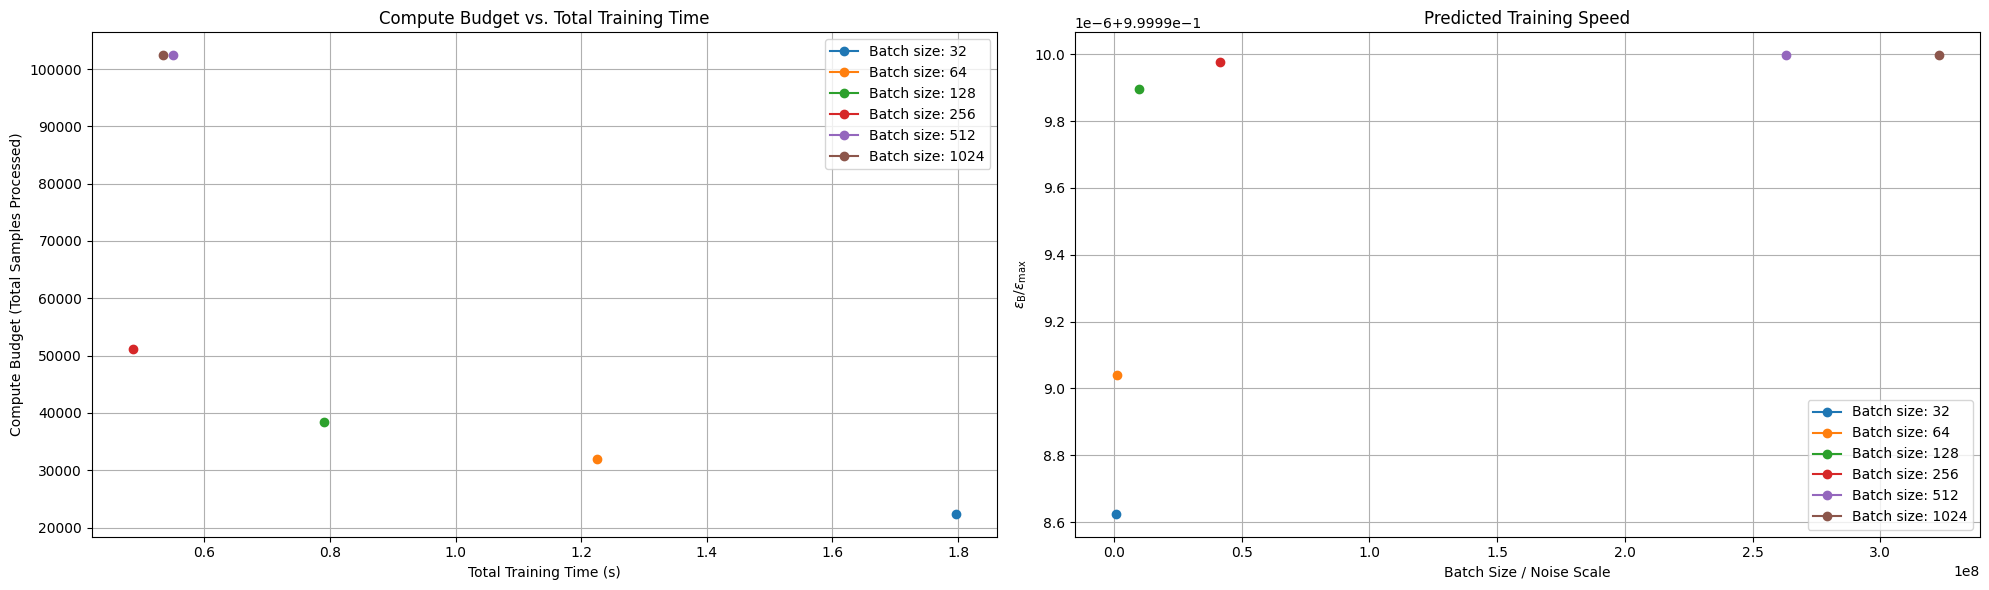

In [9]:
# Assume centralized_experiment_results is a list of tuples:
# (batch_size, results)
# where results is a dict containing:
#   - "compute_budgets": samples per epoch
#   - "training_time": time per epoch
#   - "noise_scales": list of noise scale values per epoch

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

centralized_experiment_results = [
    (batch_size, load_experiment(f"centralized_experiment_results_{batch_size}.json"))
    for batch_size in centralized_experiment_batch_sizes
]
# Left subplot: Compute Budget vs. Cumulative Training Time for each batch size
for batch_size, results in centralized_experiment_results:
    if batch_size == 16:
        continue
    # Calculate cumulative training time (sum over epochs)
    cumulative_time = np.sum(results["training_time"])
    compute_budget = np.sum(results["compute_cost"])
    axes[0].plot(cumulative_time, compute_budget, marker='o', label=f"Batch size: {batch_size}")
    
    log(INFO, f"Batch size: {batch_size}")
    log(INFO, f"Total Training Time (s): {cumulative_time}")
    log(INFO, f"Compute Budget (samples): {compute_budget}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Noise Scale vs. Cumulative Training Time for each batch size
for batch_size, results in centralized_experiment_results:
    noise_scale = np.mean(results["noise_scales"]) # do we average ??

    x_axis = batch_size / noise_scale
    y_axis = 1 / (1 + (noise_scale / batch_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Batch size: {batch_size}")
    
    log(INFO, f"Batch size: {batch_size}")
    log(INFO, f"Cumulative Training Time (s): {cumulative_time}")
    log(INFO, f"Noise Scale: {noise_scale}")


axes[1].set_xlabel("Batch Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


We can also observe that increasing batch size appears does in fact alter performance.

Furthermore, both $\beta_{\text{simple}}$ computation and the empirical results seem to indicate optimal batch sizes with magnitudes in the hundreds (100-1000).

### **FL run with varying batch sizes**

In [7]:
total_batch_results = []

for batch_size in experiment_batch_sizes:
    train_cfg = federated_train_config.copy()
    train_cfg["batch_size"] = batch_size
    ratio = np.sqrt(batch_size / 256)
    train_cfg["client_learning_rate"] = ratio * 0.01 # Same as centralized, but should be lower for FL

    test_cfg = federated_test_config.copy()
    test_cfg["batch_size"] = batch_size

    local_list_of_ids = sample_random_clients(num_total_clients, train_cfg["batch_size"], CID_CLIENT_GENERATOR)
    local_federated_client_generator = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION, lambda seq_id: local_list_of_ids[seq_id])

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = num_clients_per_round,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = num_clients_per_round,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = local_federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        target_accuracy=0.60,
        use_target_accuracy=True,
        )

    total_batch_results.append((batch_size, parameters_for_each_round, hist))

INFO flwr 2025-02-28 18:31:56,498 | flwr_core.py:105 | cid: 2530
INFO flwr 2025-02-28 18:31:56,502 | flwr_core.py:105 | cid: 2184
INFO flwr 2025-02-28 18:31:56,504 | flwr_core.py:105 | cid: 2907
INFO flwr 2025-02-28 18:31:56,505 | flwr_core.py:105 | cid: 1498
INFO flwr 2025-02-28 18:31:56,506 | flwr_core.py:105 | cid: 2338
INFO flwr 2025-02-28 18:31:56,507 | flwr_core.py:105 | cid: 2399
INFO flwr 2025-02-28 18:31:56,508 | flwr_core.py:105 | cid: 2997
INFO flwr 2025-02-28 18:31:56,508 | flwr_core.py:105 | cid: 678
INFO flwr 2025-02-28 18:31:56,509 | flwr_core.py:105 | cid: 3175
INFO flwr 2025-02-28 18:31:56,510 | flwr_core.py:105 | cid: 1363
INFO flwr 2025-02-28 18:31:56,511 | flwr_core.py:105 | cid: 1571
INFO flwr 2025-02-28 18:31:56,512 | flwr_core.py:105 | cid: 2600
INFO flwr 2025-02-28 18:31:56,513 | flwr_core.py:105 | cid: 1473
INFO flwr 2025-02-28 18:31:56,514 | flwr_core.py:105 | cid: 1260
INFO flwr 2025-02-28 18:31:56,515 | flwr_core.py:105 | cid: 1603
INFO flwr 2025-02-28 18:31

In [8]:
import pickle

def save_experiment(save_file_name, batch_size, parameters_for_each_round, hist):
    """Save experiment results using pickle.
    
    Args:
        save_file_name (str): Path to save the results
        batch_size (int): Batch size used in experiment
        parameters_for_each_round (list): List of model parameters for each round
        hist (History): Flower History object containing metrics
    """
    if os.path.exists(save_file_name):
        raise FileExistsError(f"File {save_file_name} already exists")
    
    results_dict = {
        'batch_size': batch_size,
        'parameters_for_each_round': parameters_for_each_round,
        'history': hist
    }
    
    with open(save_file_name, 'wb') as f:  # Note: 'wb' for binary write mode
        pickle.dump(results_dict, f)

def load_experiment(file_name):
    """Load experiment results from a pickle file.
    
    Args:
        file_name (str): Path to the results file
        
    Returns:
        tuple: (batch_size, parameters_for_each_round, hist)
    """
    with open(file_name, 'rb') as f:  # Note: 'rb' for binary read mode
        results_dict = pickle.load(f)
    
    return (
        results_dict['batch_size'],
        results_dict['parameters_for_each_round'],
        results_dict['history']
    )

In [10]:

for batch_size, parameters, hist in total_batch_results:
    save_experiment(f"federated_batch_results_{batch_size}.pkl", batch_size, parameters, hist)

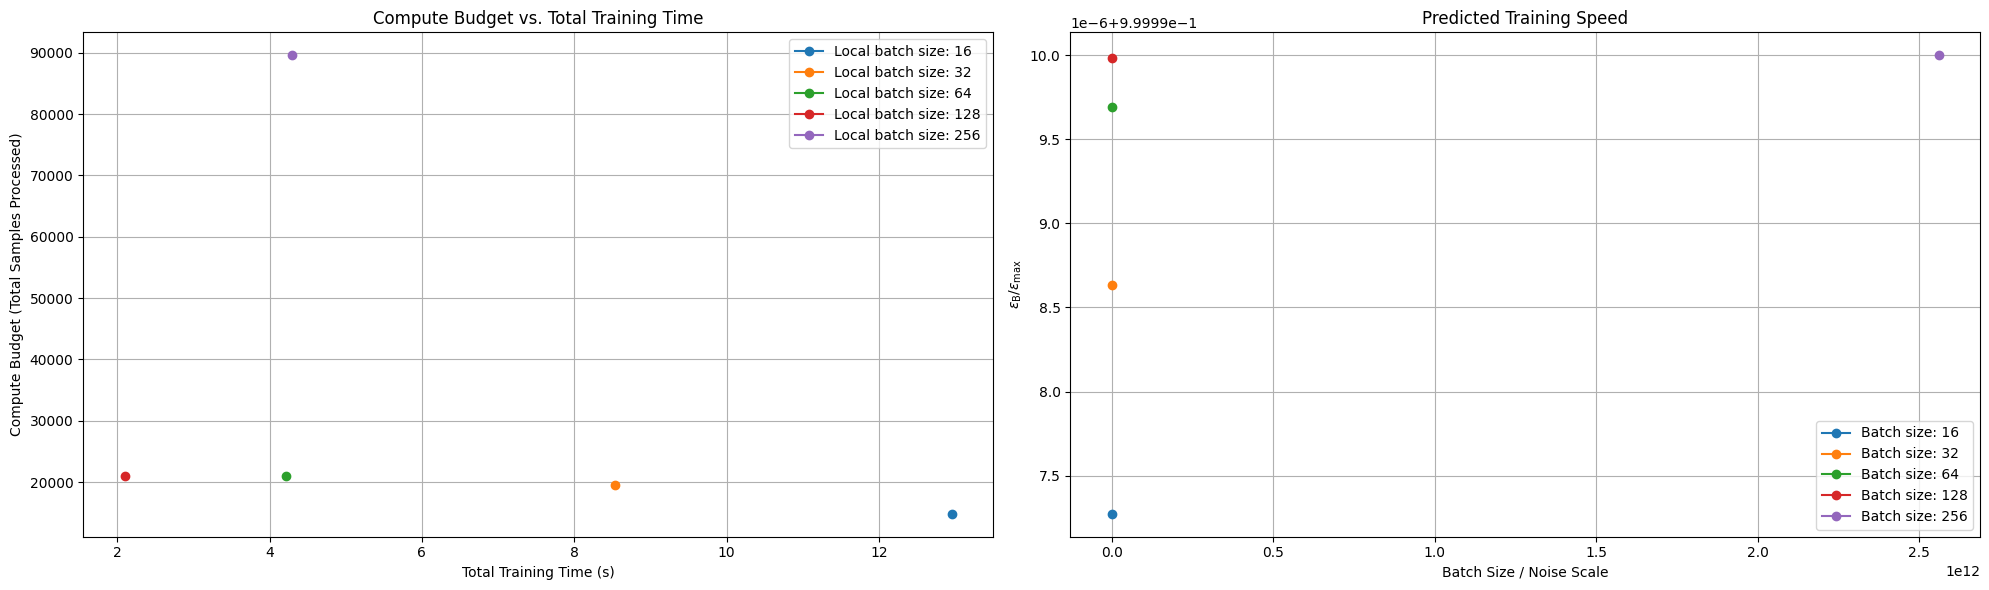

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bottom-left: Compute Budget vs Training Time
for batch_size, params, hist in total_batch_results:
    times = []
    samples = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['training_time']:
        round_times = [t for _, t in round_metrics['all']]
        times.append(np.mean(round_times))
        
    for round_idx, round_metrics in hist.metrics_distributed_fit['samples_processed']:
        round_samples = [s for _, s in round_metrics['all']]
        samples.append(np.sum(round_samples))
    
    cumulative_time = np.sum(times)
    total_samples = np.sum(samples)
    axes[0].plot(cumulative_time, total_samples, marker='o', label=f"Local batch size: {batch_size}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Bottom-right: Noise Scale Analysis
for batch_size, params, hist in total_batch_results:
    noise_scales = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['noise_scale']:
        round_noise_scales = [ns for _, ns in round_metrics['all']]
        noise_scale = np.mean(round_noise_scales)
        noise_scales.append(noise_scale)
    
    avg_noise_scale = np.mean(noise_scales)
    x_axis = batch_size / (avg_noise_scale + 1e-10)
    y_axis = 1 / (1 + (avg_noise_scale / batch_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Batch size: {batch_size}")

axes[1].set_xlabel("Batch Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [12]:
for batch_size, params, hist in total_batch_results:
    print("Batch size: ", batch_size)

    noise_scales = hist.metrics_distributed_fit['noise_scale']

    crit_batches = []
    for round, round_noise_scales in noise_scales:
        actual_noise_scales = [val for _, val in round_noise_scales['all']]
        crit_batch = compute_critical_batch(actual_noise_scales, .001)
        print("---", crit_batch)
        crit_batches.append(crit_batch)
    print(np.mean(crit_batches)) 

Batch size:  16
--- 12.536585778117669
--- 51.22522999237078
--- 21.79863112589017
--- 41.7380670627414
--- 40.81702196193497
--- 17.22276176812839
--- 20.920369098905784
--- 20.13013655025844
28.29860041729345
Batch size:  32
--- 8.778812136553965
--- 26.26769261133004
--- 44.61096089292913
--- 51.044589762921404
--- 64.5785942827554
--- 29.90838456990145
--- 22.396009814515033
--- 22.446715784201473
--- 16.165666128073035
--- 32.18817746853844
--- 17.736308358574842
30.556537437299472
Batch size:  64
--- 57.75366692602006
--- 32.6919192271007
--- 36.45559524133037
--- 111.97951302271804
--- 73.2731159697356
--- 63.68285997362363
--- 51.85478731053248
--- 44.98087555896071
--- 51.945115759916725
--- 40.24328174050069
--- 64.6988901052395
--- 40.006967328883086
--- 56.87580651721953
55.88018420629085
Batch size:  128
--- 363.57557867581306
--- 100000.0
--- 681.9006542184272
--- 28696.170262649244
--- 140.02285264640352
--- 926.7509712660146
--- 315.4250371682914
--- 640.281756724531
--

When running FL experiments with multiple batch sizes, we do observe that there must be something as "critical" batch size.

However, we must investigate how to identify it.

## **Running FL with varying cohort sizes**

In [16]:
total_cohort_results = []

for cohort_size in cohort_sizes:
    train_cfg = federated_train_config.copy()
    ratio = np.sqrt(cohort_size / 100)
    train_cfg["client_learning_rate"] = ratio * 0.01

    test_cfg = federated_test_config.copy()

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = cohort_size,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = cohort_size,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        )

    total_cohort_results.append((cohort_size, parameters_for_each_round, hist))

INFO flwr 2025-02-28 01:25:51,512 | experiments_simulation.py:165 | FL will execute for 10 rounds


INFO flwr 2025-02-28 01:25:51,514 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:25:51,515 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-28 01:25:51,515 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:25:51,517 | server_returns_parameters.py:84 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▍                                                                                                               | 19/891 [00:00<00:04, 189.39it/s]


  4%|████▊                                                                                                             | 38/891 [00:00<00:08, 103.12it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:09, 93.07it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:09, 88.38it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:00<00:09, 85.49it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:00<00:09, 83.46it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:00<00:09, 83.38it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:09, 82.63it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 88.43it/s]


INFO flwr 2025-02-28 01:25:52,798 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:25:52,798 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-28 01:25:52,799 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:25:52,800 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:25:52,802 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:25:52,803 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:25:52,808 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:25:52,811 | flwr_core.py:105 | cid: 1287


DEBUG flwr 2025-02-28 01:25:56,165 | server_returns_parameters.py:237 | fit_round 1 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 202.05it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 113.73it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:08, 100.85it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:09, 89.76it/s]


  9%|██████████                                                                                                         | 78/891 [00:00<00:09, 85.55it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:00<00:09, 83.33it/s]


 11%|████████████▍                                                                                                      | 96/891 [00:01<00:09, 82.18it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 90.51it/s]


INFO flwr 2025-02-28 01:25:57,413 | server_returns_parameters.py:120 | fit progress: (1, 370.5446116924286, {'accuracy': 0.1209375}, 4.613652497995645)


INFO flwr 2025-02-28 01:25:57,413 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:25:57,414 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:25:57,415 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:25:57,418 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:25:57,420 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:25:57,423 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:25:57,426 | flwr_core.py:105 | cid: 2782


DEBUG flwr 2025-02-28 01:26:01,125 | server_returns_parameters.py:237 | fit_round 2 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▊                                                                                                               | 22/891 [00:00<00:03, 219.55it/s]


  5%|█████▋                                                                                                            | 44/891 [00:00<00:07, 109.95it/s]


  7%|███████▍                                                                                                          | 58/891 [00:00<00:08, 100.54it/s]


  8%|█████████                                                                                                          | 70/891 [00:00<00:08, 97.01it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:00<00:09, 88.90it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:00<00:09, 88.43it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 96.10it/s]


INFO flwr 2025-02-28 01:26:02,310 | server_returns_parameters.py:120 | fit progress: (2, 307.95208263397217, {'accuracy': 0.21375}, 9.51070132793393)


INFO flwr 2025-02-28 01:26:02,310 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:02,311 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:02,311 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:26:02,314 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:26:02,315 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:26:02,317 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:26:02,318 | flwr_core.py:105 | cid: 275


DEBUG flwr 2025-02-28 01:26:05,780 | server_returns_parameters.py:237 | fit_round 3 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▎                                                                                                               | 18/891 [00:00<00:04, 177.72it/s]


  4%|████▌                                                                                                             | 36/891 [00:00<00:06, 122.47it/s]


  6%|██████▍                                                                                                           | 50/891 [00:00<00:08, 104.15it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:08, 96.92it/s]


  8%|█████████▍                                                                                                         | 73/891 [00:00<00:08, 94.29it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:00<00:08, 92.98it/s]


 10%|████████████                                                                                                       | 93/891 [00:00<00:08, 91.96it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 97.84it/s]

INFO flwr 2025-02-28 01:26:06,944 | server_returns_parameters.py:120 | fit progress: (3, 280.22183549404144, {'accuracy': 0.3178125}, 14.145226084976457)


INFO flwr 2025-02-28 01:26:06,945 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:06,946 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:06,947 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:26:06,950 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:26:06,953 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:26:06,955 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:26:06,957 | flwr_core.py:105 | cid: 2471


DEBUG flwr 2025-02-28 01:26:09,384 | server_returns_parameters.py:237 | fit_round 4 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 202.89it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 109.57it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:08, 97.68it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:08, 93.73it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:00<00:08, 92.31it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:00<00:08, 90.72it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:08, 88.36it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 94.52it/s]


INFO flwr 2025-02-28 01:26:10,585 | server_returns_parameters.py:120 | fit progress: (4, 244.85200786590576, {'accuracy': 0.42125}, 17.786514865932986)


INFO flwr 2025-02-28 01:26:10,586 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:10,586 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:10,587 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:26:10,589 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:26:10,590 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:26:10,592 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:26:10,596 | flwr_core.py:105 | cid: 3175


DEBUG flwr 2025-02-28 01:26:13,771 | server_returns_parameters.py:237 | fit_round 5 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 206.77it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 113.94it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:08, 102.43it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:08, 94.60it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:00<00:08, 91.53it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:00<00:09, 88.68it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:09, 87.23it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 95.28it/s]


INFO flwr 2025-02-28 01:26:14,975 | server_returns_parameters.py:120 | fit progress: (5, 253.71549332141876, {'accuracy': 0.396875}, 22.176160353934392)


INFO flwr 2025-02-28 01:26:14,976 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:14,977 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:14,978 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:26:14,980 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:26:14,981 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:26:14,982 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:26:14,985 | flwr_core.py:105 | cid: 2614


DEBUG flwr 2025-02-28 01:26:17,352 | server_returns_parameters.py:237 | fit_round 6 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▊                                                                                                               | 22/891 [00:00<00:04, 214.81it/s]


  5%|█████▋                                                                                                            | 44/891 [00:00<00:07, 108.11it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:08, 97.24it/s]


  8%|█████████                                                                                                          | 70/891 [00:00<00:08, 92.35it/s]


  9%|██████████▎                                                                                                        | 80/891 [00:00<00:09, 89.78it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:00<00:09, 88.60it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 87.43it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 94.25it/s]


INFO flwr 2025-02-28 01:26:18,555 | server_returns_parameters.py:120 | fit progress: (6, 241.68832159042358, {'accuracy': 0.4465625}, 25.75616056099534)


INFO flwr 2025-02-28 01:26:18,555 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:18,556 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:18,557 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:26:18,559 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:26:18,562 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:26:18,564 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:26:18,566 | flwr_core.py:105 | cid: 2907


DEBUG flwr 2025-02-28 01:26:21,539 | server_returns_parameters.py:237 | fit_round 7 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 203.43it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 117.40it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:08, 102.47it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:08, 95.27it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:00<00:08, 91.81it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:00<00:09, 88.69it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:09, 86.94it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 95.51it/s]


INFO flwr 2025-02-28 01:26:22,734 | server_returns_parameters.py:120 | fit progress: (7, 243.47910976409912, {'accuracy': 0.445}, 29.93494233302772)


INFO flwr 2025-02-28 01:26:22,734 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:22,735 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:22,736 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:26:22,737 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:26:22,739 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:26:22,741 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:26:22,742 | flwr_core.py:105 | cid: 3020


DEBUG flwr 2025-02-28 01:26:24,871 | server_returns_parameters.py:237 | fit_round 8 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 205.21it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 111.55it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:08, 95.99it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:09, 89.12it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:00<00:09, 88.25it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:00<00:09, 87.18it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:08, 89.01it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 94.08it/s]


INFO flwr 2025-02-28 01:26:26,076 | server_returns_parameters.py:120 | fit progress: (8, 207.76125359535217, {'accuracy': 0.49375}, 33.27668500493746)


INFO flwr 2025-02-28 01:26:26,077 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:26,078 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:26,079 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:26:26,082 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:26:26,084 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:26:26,086 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:26:26,089 | flwr_core.py:105 | cid: 1770


DEBUG flwr 2025-02-28 01:26:29,109 | server_returns_parameters.py:237 | fit_round 9 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 201.15it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 109.36it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:08, 100.35it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:08, 95.74it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:00<00:08, 92.68it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:00<00:08, 91.43it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:08, 88.77it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 95.87it/s]


INFO flwr 2025-02-28 01:26:30,298 | server_returns_parameters.py:120 | fit progress: (9, 262.97781920433044, {'accuracy': 0.3915625}, 37.49870338791516)


INFO flwr 2025-02-28 01:26:30,298 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:30,299 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:30,299 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:26:30,301 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:26:30,303 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:26:30,305 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:26:30,308 | flwr_core.py:105 | cid: 1852


DEBUG flwr 2025-02-28 01:26:32,076 | server_returns_parameters.py:237 | fit_round 10 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 206.79it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 109.43it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:08, 97.86it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:08, 92.27it/s]


  9%|██████████                                                                                                         | 78/891 [00:00<00:09, 89.49it/s]


 10%|███████████▎                                                                                                       | 88/891 [00:00<00:09, 86.43it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:09, 85.02it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 92.55it/s]


INFO flwr 2025-02-28 01:26:33,303 | server_returns_parameters.py:120 | fit progress: (10, 207.17345088720322, {'accuracy': 0.5090625}, 40.50399627292063)


INFO flwr 2025-02-28 01:26:33,303 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-28 01:26:33,304 | server_returns_parameters.py:150 | FL finished in 40.50480121001601


INFO flwr 2025-02-28 01:26:33,304 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:26:33,305 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.10565958748902043, 'all': [(4, 0.09818555228412151), (8, 0.10823167115449905), (4, 0.10628992132842541), (8, 0.10429108515381813), (7, 0.10819475246327263)]}), (2, {'avg': 0.07234205757126663, 'all': [(5, 0.0818282887339592), (8, 0.06826606905087829), (4, 0.09276132471859455), (5, 0.0843994900584221), (11, 0.05808865041895346)]}), (3, {'avg': 0.05348719707266851, 'all': [(10, 0.04792364537715912), (7, 0.06478514788406235), (8, 0.042618337320163846), (4, 0.049445112235844135), (4, 0.07340446673333645)]}), (4, {'avg': 0.037775887599722904, 'all': [(4, 0.04703175462782383), (5, 0.03852110877633095), (4, 0.035851589404046535), (4, 0.03539664810523391), (5, 0.033068802952766416)]}), (5, {'avg': 0.034203497258325416, 'all': [(8, 0.035097850020974874), (4, 0.03121413988992572), (10, 0.034966851212084295), (4, 0.033641007263213396), (4, 0.03405825421214104)]}), (6, {'avg': 0.02889404

INFO flwr 2025-02-28 01:26:33,305 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:26:33,305 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 370.5446116924286), (2, 307.95208263397217), (3, 280.22183549404144), (4, 244.85200786590576), (5, 253.71549332141876), (6, 241.68832159042358), (7, 243.47910976409912), (8, 207.76125359535217), (9, 262.97781920433044), (10, 207.17345088720322)]


INFO flwr 2025-02-28 01:26:33,305 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.1209375), (2, 0.21375), (3, 0.3178125), (4, 0.42125), (5, 0.396875), (6, 0.4465625), (7, 0.445), (8, 0.49375), (9, 0.3915625), (10, 0.5090625)]}


INFO flwr 2025-02-28 01:26:33,317 | experiments_simulation.py:165 | FL will execute for 10 rounds


INFO flwr 2025-02-28 01:26:33,319 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:26:33,320 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-28 01:26:33,321 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:26:33,322 | server_returns_parameters.py:84 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▍                                                                                                               | 19/891 [00:00<00:04, 187.32it/s]


  4%|████▊                                                                                                             | 38/891 [00:00<00:07, 115.44it/s]


  6%|██████▋                                                                                                           | 52/891 [00:00<00:08, 100.67it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:08, 95.14it/s]


  8%|█████████▍                                                                                                         | 73/891 [00:00<00:09, 90.20it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:00<00:08, 90.11it/s]


 10%|████████████                                                                                                       | 93/891 [00:00<00:09, 88.26it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 93.86it/s]


INFO flwr 2025-02-28 01:26:34,548 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:26:34,549 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-28 01:26:34,549 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:26:34,550 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:26:34,553 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:26:34,555 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:26:34,556 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:26:34,559 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:26:34,561 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:26:34,564 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:26:34,567 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:26:34,569 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:26:34,570 | flwr_core.py:105 | cid: 2782


DEBUG flwr 2025-02-28 01:26:42,387 | server_returns_parameters.py:237 | fit_round 1 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▏                                                                                                               | 17/891 [00:00<00:05, 165.55it/s]


  4%|████▎                                                                                                             | 34/891 [00:00<00:07, 113.20it/s]


  5%|██████                                                                                                             | 47/891 [00:00<00:08, 95.48it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:09, 90.87it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:09, 86.30it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:00<00:09, 84.51it/s]


 10%|███████████                                                                                                        | 86/891 [00:00<00:09, 82.69it/s]


 11%|████████████▎                                                                                                      | 95/891 [00:01<00:09, 82.26it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 88.29it/s]


INFO flwr 2025-02-28 01:26:43,694 | server_returns_parameters.py:120 | fit progress: (1, 374.5705215930939, {'accuracy': 0.071875}, 9.145026962971315)


INFO flwr 2025-02-28 01:26:43,694 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:43,695 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:26:43,696 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:26:43,698 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:26:43,699 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:26:43,701 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:26:43,708 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:26:43,710 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:26:43,715 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:26:43,718 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:26:43,723 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:26:43,727 | flwr_core.py:105 | cid: 1260


DEBUG flwr 2025-02-28 01:26:50,863 | server_returns_parameters.py:237 | fit_round 2 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▍                                                                                                               | 19/891 [00:00<00:04, 186.58it/s]


  4%|████▊                                                                                                             | 38/891 [00:00<00:08, 103.86it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:09, 91.95it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:10, 82.48it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:00<00:10, 79.63it/s]


  9%|██████████▎                                                                                                        | 80/891 [00:00<00:10, 78.05it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:01<00:10, 78.94it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:10, 78.34it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 83.73it/s]


INFO flwr 2025-02-28 01:26:52,211 | server_returns_parameters.py:120 | fit progress: (2, 302.92192554473877, {'accuracy': 0.2990625}, 17.66253783099819)


INFO flwr 2025-02-28 01:26:52,212 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:52,213 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:26:52,214 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:26:52,216 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:26:52,219 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:26:52,222 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:26:52,223 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:26:52,227 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:26:52,232 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:26:52,233 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:26:52,238 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:26:52,246 | flwr_core.py:105 | cid: 1009


DEBUG flwr 2025-02-28 01:26:58,552 | server_returns_parameters.py:237 | fit_round 3 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|█▊                                                                                                                | 14/891 [00:00<00:06, 131.90it/s]


  3%|███▌                                                                                                              | 28/891 [00:00<00:07, 114.77it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:08, 94.83it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:09, 91.11it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:10, 82.96it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:11, 73.45it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:00<00:11, 70.89it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:11, 71.35it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:10, 73.42it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 79.28it/s]


INFO flwr 2025-02-28 01:27:00,047 | server_returns_parameters.py:120 | fit progress: (3, 244.5242544412613, {'accuracy': 0.4221875}, 25.49845913297031)


INFO flwr 2025-02-28 01:27:00,048 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:27:00,049 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:27:00,049 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:27:00,052 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:27:00,055 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:27:00,059 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:27:00,063 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:27:00,066 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:27:00,069 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:27:00,071 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:27:00,075 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:27:00,080 | flwr_core.py:105 | cid: 1258


DEBUG flwr 2025-02-28 01:27:06,120 | server_returns_parameters.py:237 | fit_round 4 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 204.27it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:05, 159.92it/s]


  7%|███████▊                                                                                                          | 61/891 [00:00<00:04, 169.02it/s]


  9%|██████████▎                                                                                                       | 81/891 [00:00<00:04, 178.86it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:04, 178.08it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:04, 173.73it/s]


INFO flwr 2025-02-28 01:27:06,874 | server_returns_parameters.py:120 | fit progress: (4, 254.24587786197662, {'accuracy': 0.428125}, 32.325544487917796)


INFO flwr 2025-02-28 01:27:06,875 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:27:06,876 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:27:06,876 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:27:06,877 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:27:06,879 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:27:06,882 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:27:06,884 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:27:06,886 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:27:06,887 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:27:06,889 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:27:06,891 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:27:06,895 | flwr_core.py:105 | cid: 937


DEBUG flwr 2025-02-28 01:27:12,961 | server_returns_parameters.py:237 | fit_round 5 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 83.68it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 85.91it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 85.86it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:09, 85.92it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:09, 85.57it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:09, 86.09it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:09, 83.22it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:00<00:09, 83.26it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:00<00:09, 84.46it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:09, 87.76it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 86.52it/s]


INFO flwr 2025-02-28 01:27:14,266 | server_returns_parameters.py:120 | fit progress: (5, 269.7255879640579, {'accuracy': 0.3634375}, 39.716819916968234)


INFO flwr 2025-02-28 01:27:14,266 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:27:14,268 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:27:14,269 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:27:14,271 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:27:14,274 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:27:14,275 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:27:14,279 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:27:14,282 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:27:14,287 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:27:14,289 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:27:14,293 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:27:14,295 | flwr_core.py:105 | cid: 2907


DEBUG flwr 2025-02-28 01:27:20,845 | server_returns_parameters.py:237 | fit_round 6 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▍                                                                                                                | 11/891 [00:00<00:08, 103.53it/s]


  2%|██▊                                                                                                                | 22/891 [00:00<00:09, 96.21it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:09, 89.32it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:09, 90.31it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:09, 89.89it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:09, 85.37it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:00<00:09, 86.42it/s]


  9%|██████████▎                                                                                                        | 80/891 [00:00<00:09, 86.24it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:01<00:09, 85.26it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:09, 86.05it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 87.02it/s]


INFO flwr 2025-02-28 01:27:22,230 | server_returns_parameters.py:120 | fit progress: (6, 237.57622200250626, {'accuracy': 0.50375}, 47.68074532796163)


INFO flwr 2025-02-28 01:27:22,230 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:27:22,231 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:27:22,231 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:27:22,234 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:27:22,237 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:27:22,240 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:27:22,241 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:27:22,243 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:27:22,245 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:27:22,246 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:27:22,247 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:27:22,250 | flwr_core.py:105 | cid: 2343


DEBUG flwr 2025-02-28 01:27:29,546 | server_returns_parameters.py:237 | fit_round 7 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▌                                                                                                                | 12/891 [00:00<00:08, 106.46it/s]


  3%|██▉                                                                                                                | 23/891 [00:00<00:09, 89.58it/s]


  4%|████▍                                                                                                              | 34/891 [00:00<00:08, 97.29it/s]


  5%|██████▏                                                                                                           | 48/891 [00:00<00:07, 110.21it/s]


  7%|███████▉                                                                                                          | 62/891 [00:00<00:07, 117.89it/s]


  9%|█████████▋                                                                                                        | 76/891 [00:00<00:06, 122.63it/s]


 10%|███████████▌                                                                                                      | 90/891 [00:00<00:06, 126.41it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 117.10it/s]


INFO flwr 2025-02-28 01:27:30,633 | server_returns_parameters.py:120 | fit progress: (7, 228.08820521831512, {'accuracy': 0.4759375}, 56.08434921002481)


INFO flwr 2025-02-28 01:27:30,634 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:27:30,635 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:27:30,636 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:27:30,638 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:27:30,640 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:27:30,642 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:27:30,645 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:27:30,647 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:27:30,649 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:27:30,653 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:27:30,658 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:27:30,660 | flwr_core.py:105 | cid: 3178


DEBUG flwr 2025-02-28 01:27:36,281 | server_returns_parameters.py:237 | fit_round 8 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 204.69it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:04, 203.79it/s]


  7%|████████                                                                                                          | 63/891 [00:00<00:04, 201.64it/s]


  9%|██████████▋                                                                                                       | 84/891 [00:00<00:03, 202.07it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:03, 203.83it/s]


INFO flwr 2025-02-28 01:27:36,918 | server_returns_parameters.py:120 | fit progress: (8, 189.27203091979027, {'accuracy': 0.5678125}, 62.369278236990795)


INFO flwr 2025-02-28 01:27:36,919 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:27:36,919 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:27:36,920 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:27:36,921 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:27:36,923 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:27:36,927 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:27:36,930 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:27:36,932 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:27:36,933 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:27:36,936 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:27:36,942 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:27:36,948 | flwr_core.py:105 | cid: 70


DEBUG flwr 2025-02-28 01:27:43,680 | server_returns_parameters.py:237 | fit_round 9 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 85.77it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:09, 88.02it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:09, 91.94it/s]


  4%|████▉                                                                                                              | 38/891 [00:00<00:09, 90.86it/s]


  5%|██████▏                                                                                                            | 48/891 [00:00<00:09, 92.36it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:09, 92.48it/s]


  8%|█████████                                                                                                          | 70/891 [00:00<00:08, 99.49it/s]


  9%|██████████▍                                                                                                       | 82/891 [00:00<00:07, 104.34it/s]


 11%|████████████                                                                                                      | 94/891 [00:00<00:07, 108.07it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:07, 98.91it/s]


INFO flwr 2025-02-28 01:27:44,868 | server_returns_parameters.py:120 | fit progress: (9, 213.14875066280365, {'accuracy': 0.535}, 70.3189174629515)


INFO flwr 2025-02-28 01:27:44,868 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:27:44,869 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:27:44,870 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:27:44,872 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:27:44,875 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:27:44,878 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:27:44,880 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:27:44,883 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:27:44,884 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:27:44,885 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:27:44,887 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:27:44,889 | flwr_core.py:105 | cid: 2274


DEBUG flwr 2025-02-28 01:27:51,667 | server_returns_parameters.py:237 | fit_round 10 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▍                                                                                                                | 11/891 [00:00<00:08, 106.44it/s]


  3%|██▉                                                                                                               | 23/891 [00:00<00:07, 112.16it/s]


  4%|████▍                                                                                                             | 35/891 [00:00<00:07, 111.92it/s]


  5%|██████                                                                                                            | 47/891 [00:00<00:07, 109.66it/s]


  7%|███████▍                                                                                                          | 58/891 [00:00<00:07, 108.53it/s]


  8%|████████▊                                                                                                         | 69/891 [00:00<00:07, 108.59it/s]


  9%|██████████▎                                                                                                       | 81/891 [00:00<00:07, 111.83it/s]


 10%|███████████▉                                                                                                      | 93/891 [00:00<00:07, 113.92it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 110.18it/s]


INFO flwr 2025-02-28 01:27:52,736 | server_returns_parameters.py:120 | fit progress: (10, 227.2877472639084, {'accuracy': 0.491875}, 78.18683011492249)


INFO flwr 2025-02-28 01:27:52,736 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-28 01:27:52,737 | server_returns_parameters.py:150 | FL finished in 78.18782845302485


INFO flwr 2025-02-28 01:27:52,737 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:27:52,738 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.10129949066322297, 'all': [(8, 0.0904895169660449), (11, 0.09691431441090324), (8, 0.10983669944107533), (4, 0.1009509451687336), (4, 0.09970851615071297), (4, 0.10603524185717106), (8, 0.10630209371447563), (5, 0.09935470521450043), (7, 0.10580879236970629), (5, 0.09997391551733018)]}), (2, {'avg': 0.07291004326889071, 'all': [(4, 0.08352193422615528), (8, 0.05947327567264438), (4, 0.09323608130216599), (4, 0.08395145833492279), (8, 0.07031656429171562), (5, 0.0748570553958416), (10, 0.05457763746380806), (4, 0.08866654150187969), (5, 0.08128833770751953), (7, 0.07705234736204147)]}), (3, {'avg': 0.03706152185511131, 'all': [(5, 0.029597285389900207), (4, 0.04337553400546312), (10, 0.035603902861475946), (5, 0.0373326264321804), (8, 0.027282089926302433), (4, 0.04589029308408499), (4, 0.03944742400199175), (4, 0.0420087780803442), (4, 0.04155659396201372), (4, 0.042284834198

INFO flwr 2025-02-28 01:27:52,738 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:27:52,739 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 374.5705215930939), (2, 302.92192554473877), (3, 244.5242544412613), (4, 254.24587786197662), (5, 269.7255879640579), (6, 237.57622200250626), (7, 228.08820521831512), (8, 189.27203091979027), (9, 213.14875066280365), (10, 227.2877472639084)]


INFO flwr 2025-02-28 01:27:52,739 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.071875), (2, 0.2990625), (3, 0.4221875), (4, 0.428125), (5, 0.3634375), (6, 0.50375), (7, 0.4759375), (8, 0.5678125), (9, 0.535), (10, 0.491875)]}


INFO flwr 2025-02-28 01:27:52,750 | experiments_simulation.py:165 | FL will execute for 10 rounds


INFO flwr 2025-02-28 01:27:52,755 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:27:52,755 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-28 01:27:52,756 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:27:52,757 | server_returns_parameters.py:84 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▌                                                                                                               | 20/891 [00:00<00:04, 190.48it/s]


  4%|█████                                                                                                             | 40/891 [00:00<00:04, 190.67it/s]


  7%|███████▊                                                                                                          | 61/891 [00:00<00:04, 196.48it/s]


  9%|██████████▍                                                                                                       | 82/891 [00:00<00:04, 199.87it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:04, 197.34it/s]


INFO flwr 2025-02-28 01:27:53,409 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:27:53,409 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-28 01:27:53,410 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:27:53,411 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:27:53,412 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:27:53,415 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:27:53,421 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:27:53,424 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:27:53,425 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:27:53,427 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:27:53,428 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:27:53,431 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:27:53,431 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:27:53,435 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:27:53,436 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:27:53,439 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:27:53,442 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:27:53,444 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:27:53,450 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:27:53,453 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:27:53,455 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:27:53,466 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:27:53,473 | flwr_core.py:105 | cid: 2364


DEBUG flwr 2025-02-28 01:28:08,348 | server_returns_parameters.py:237 | fit_round 1 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▎                                                                                                               | 18/891 [00:00<00:04, 179.72it/s]


  4%|████▊                                                                                                             | 38/891 [00:00<00:04, 189.56it/s]


  6%|███████▎                                                                                                          | 57/891 [00:00<00:04, 184.89it/s]


  9%|█████████▋                                                                                                        | 76/891 [00:00<00:05, 158.56it/s]


 11%|████████████                                                                                                      | 94/891 [00:00<00:04, 164.99it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:04, 168.30it/s]


INFO flwr 2025-02-28 01:28:09,127 | server_returns_parameters.py:120 | fit progress: (1, 380.9852383136749, {'accuracy': 0.075}, 15.717945000971667)


INFO flwr 2025-02-28 01:28:09,128 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:28:09,129 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:28:09,130 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:28:09,132 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:28:09,135 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:28:09,139 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:28:09,140 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:28:09,144 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:28:09,148 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:28:09,151 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:28:09,156 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:28:09,159 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:28:09,164 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:28:09,166 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:28:09,168 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:28:09,172 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:28:09,174 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:28:09,176 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:28:09,179 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:28:09,180 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:28:09,189 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:28:09,190 | flwr_core.py:105 | cid: 2504


DEBUG flwr 2025-02-28 01:28:21,312 | server_returns_parameters.py:237 | fit_round 2 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|█▉                                                                                                                | 15/891 [00:00<00:06, 144.12it/s]


  3%|███▊                                                                                                              | 30/891 [00:00<00:06, 134.19it/s]


  5%|██████▏                                                                                                           | 48/891 [00:00<00:05, 152.18it/s]


  7%|████████▏                                                                                                         | 64/891 [00:00<00:06, 129.73it/s]


  9%|██████████▍                                                                                                       | 82/891 [00:00<00:05, 144.42it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 149.46it/s]


INFO flwr 2025-02-28 01:28:22,162 | server_returns_parameters.py:120 | fit progress: (2, 296.6401159763336, {'accuracy': 0.3071875}, 28.752492042956874)


INFO flwr 2025-02-28 01:28:22,162 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:28:22,163 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:28:22,164 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:28:22,165 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:28:22,167 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:28:22,170 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:28:22,174 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:28:22,178 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:28:22,181 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:28:22,184 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:28:22,186 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:28:22,188 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:28:22,191 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:28:22,194 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:28:22,197 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:28:22,201 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:28:22,205 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:28:22,210 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:28:22,213 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:28:22,218 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:28:22,220 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:28:22,224 | flwr_core.py:105 | cid: 2434


DEBUG flwr 2025-02-28 01:28:35,075 | server_returns_parameters.py:237 | fit_round 3 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 78.41it/s]


  2%|██▏                                                                                                                | 17/891 [00:00<00:10, 80.65it/s]


  3%|███▎                                                                                                               | 26/891 [00:00<00:10, 79.48it/s]


  4%|████▍                                                                                                              | 34/891 [00:00<00:10, 78.76it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:10, 78.25it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:10, 79.59it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:10, 79.94it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:10, 76.83it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:00<00:10, 77.56it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:10, 78.92it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:09, 81.06it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 78.84it/s]


INFO flwr 2025-02-28 01:28:36,527 | server_returns_parameters.py:120 | fit progress: (3, 249.713276386261, {'accuracy': 0.405625}, 43.11730407795403)


INFO flwr 2025-02-28 01:28:36,527 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:28:36,528 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:28:36,529 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:28:36,529 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:28:36,531 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:28:36,534 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:28:36,537 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:28:36,538 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:28:36,542 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:28:36,548 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:28:36,553 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:28:36,555 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:28:36,557 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:28:36,564 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:28:36,572 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:28:36,576 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:28:36,583 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:28:36,596 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:28:36,601 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:28:36,607 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:28:36,617 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:28:36,618 | flwr_core.py:105 | cid: 1633


DEBUG flwr 2025-02-28 01:28:48,845 | server_returns_parameters.py:237 | fit_round 4 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 72.23it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 71.71it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 74.28it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 76.26it/s]


  5%|█████▎                                                                                                             | 41/891 [00:00<00:10, 80.68it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:10, 81.04it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:11, 75.63it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:10, 80.80it/s]


  9%|██████████                                                                                                         | 78/891 [00:00<00:09, 82.76it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:01<00:09, 82.57it/s]


 11%|████████████▍                                                                                                      | 96/891 [00:01<00:09, 83.74it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 79.90it/s]


INFO flwr 2025-02-28 01:28:50,335 | server_returns_parameters.py:120 | fit progress: (4, 228.829780459404, {'accuracy': 0.48125}, 56.92576526897028)


INFO flwr 2025-02-28 01:28:50,336 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:28:50,337 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:28:50,338 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:28:50,340 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:28:50,343 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:28:50,346 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:28:50,350 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:28:50,354 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:28:50,359 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:28:50,364 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:28:50,366 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:28:50,367 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:28:50,368 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:28:50,369 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:28:50,371 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:28:50,373 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:28:50,375 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:28:50,379 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:28:50,380 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:28:50,381 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:28:50,400 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:28:50,407 | flwr_core.py:105 | cid: 3068


DEBUG flwr 2025-02-28 01:29:04,629 | server_returns_parameters.py:237 | fit_round 5 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▍                                                                                                                | 11/891 [00:00<00:08, 108.92it/s]


  2%|██▊                                                                                                                | 22/891 [00:00<00:10, 85.76it/s]


  3%|████                                                                                                               | 31/891 [00:00<00:10, 82.87it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:10, 84.93it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:09, 85.12it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:10, 82.88it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:09, 82.88it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:00<00:09, 83.08it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:09, 81.68it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:10, 78.60it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 81.64it/s]


INFO flwr 2025-02-28 01:29:06,089 | server_returns_parameters.py:120 | fit progress: (5, 239.24020373821259, {'accuracy': 0.4975}, 72.67951826797798)


INFO flwr 2025-02-28 01:29:06,089 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:29:06,090 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:29:06,091 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:29:06,093 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:29:06,096 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:29:06,098 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:29:06,100 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:29:06,103 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:29:06,104 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:29:06,106 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:29:06,108 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:29:06,109 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:29:06,110 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:29:06,113 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:29:06,116 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:29:06,118 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:29:06,121 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:29:06,125 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:29:06,126 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:29:06,129 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:29:06,130 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:29:06,131 | flwr_core.py:105 | cid: 1770


DEBUG flwr 2025-02-28 01:29:18,729 | server_returns_parameters.py:237 | fit_round 6 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 65.91it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:12, 68.05it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 64.33it/s]


  3%|███▊                                                                                                               | 30/891 [00:00<00:11, 71.99it/s]


  4%|█████                                                                                                              | 39/891 [00:00<00:11, 76.82it/s]


  5%|██████▏                                                                                                            | 48/891 [00:00<00:10, 80.03it/s]


  6%|███████▎                                                                                                           | 57/891 [00:00<00:10, 78.78it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:09, 82.73it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:00<00:09, 83.41it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:10, 79.58it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:10, 79.00it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 76.87it/s]


INFO flwr 2025-02-28 01:29:20,215 | server_returns_parameters.py:120 | fit progress: (6, 209.01029872894287, {'accuracy': 0.5596875}, 86.80560382292606)


INFO flwr 2025-02-28 01:29:20,216 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:29:20,217 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:29:20,218 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:29:20,220 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:29:20,221 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:29:20,223 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:29:20,225 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:29:20,229 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:29:20,233 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:29:20,235 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:29:20,238 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:29:20,240 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:29:20,242 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:29:20,244 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:29:20,247 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:29:20,249 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:29:20,252 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:29:20,254 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:29:20,257 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:29:20,259 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:29:20,265 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:29:20,266 | flwr_core.py:105 | cid: 2736


DEBUG flwr 2025-02-28 01:29:32,793 | server_returns_parameters.py:237 | fit_round 7 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▋                                                                                                                | 13/891 [00:00<00:06, 127.20it/s]


  3%|███▎                                                                                                               | 26/891 [00:00<00:09, 87.10it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 82.93it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:11, 76.86it/s]


  6%|██████▊                                                                                                            | 53/891 [00:00<00:11, 75.17it/s]


  7%|███████▊                                                                                                           | 61/891 [00:00<00:11, 73.45it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:11, 72.33it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:01<00:11, 71.68it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:11, 71.74it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:11, 67.88it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 73.63it/s]


INFO flwr 2025-02-28 01:29:34,389 | server_returns_parameters.py:120 | fit progress: (7, 189.37704241275787, {'accuracy': 0.6025}, 100.97928480897099)


INFO flwr 2025-02-28 01:29:34,390 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:29:34,391 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:29:34,392 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:29:34,394 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:29:34,396 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:29:34,397 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:29:34,400 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:29:34,402 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:29:34,404 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:29:34,408 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:29:34,413 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:29:34,415 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:29:34,420 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:29:34,427 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:29:34,428 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:29:34,430 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:29:34,437 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:29:34,438 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:29:34,442 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:29:34,446 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:29:34,454 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:29:34,460 | flwr_core.py:105 | cid: 2399


DEBUG flwr 2025-02-28 01:29:49,997 | server_returns_parameters.py:237 | fit_round 8 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▎                                                                                                                 | 10/891 [00:00<00:09, 92.08it/s]


  2%|██▌                                                                                                                | 20/891 [00:00<00:10, 81.18it/s]


  3%|███▋                                                                                                               | 29/891 [00:00<00:12, 69.18it/s]


  4%|████▊                                                                                                              | 37/891 [00:00<00:11, 71.26it/s]


  5%|█████▉                                                                                                             | 46/891 [00:00<00:11, 75.06it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:10, 80.14it/s]


  7%|████████▍                                                                                                          | 65/891 [00:00<00:10, 81.92it/s]


  8%|█████████▌                                                                                                         | 74/891 [00:00<00:09, 83.01it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:10, 78.44it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:10, 75.68it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:10, 73.85it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 75.68it/s]


INFO flwr 2025-02-28 01:29:51,556 | server_returns_parameters.py:120 | fit progress: (8, 189.81800997257233, {'accuracy': 0.55125}, 118.14658000296913)


INFO flwr 2025-02-28 01:29:51,557 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:29:51,558 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:29:51,559 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:29:51,561 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:29:51,564 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:29:51,567 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:29:51,570 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:29:51,574 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:29:51,577 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:29:51,580 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:29:51,585 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:29:51,589 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:29:51,593 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:29:51,596 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:29:51,598 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:29:51,600 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:29:51,604 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:29:51,610 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:29:51,616 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:29:51,619 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:29:51,626 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:29:51,629 | flwr_core.py:105 | cid: 1446


DEBUG flwr 2025-02-28 01:30:07,966 | server_returns_parameters.py:237 | fit_round 9 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 82.43it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 81.10it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 79.22it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:11, 77.29it/s]


  5%|█████▋                                                                                                             | 44/891 [00:00<00:10, 78.16it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:10, 77.81it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:11, 70.27it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:11, 69.86it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:01<00:11, 69.74it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:11, 71.52it/s]


 10%|███████████▊                                                                                                       | 92/891 [00:01<00:10, 72.91it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 73.18it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 73.16it/s]


INFO flwr 2025-02-28 01:30:09,486 | server_returns_parameters.py:120 | fit progress: (9, 228.11440533399582, {'accuracy': 0.5196875}, 136.0764339719899)


INFO flwr 2025-02-28 01:30:09,486 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:30:09,488 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:30:09,488 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:30:09,491 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:30:09,492 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:30:09,494 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:30:09,495 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:30:09,497 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:30:09,499 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:30:09,499 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:30:09,502 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:30:09,510 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:30:09,512 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:30:09,514 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:30:09,517 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:30:09,517 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:30:09,519 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:30:09,520 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:30:09,523 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:30:09,528 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:30:09,532 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:30:09,536 | flwr_core.py:105 | cid: 2070


DEBUG flwr 2025-02-28 01:30:22,353 | server_returns_parameters.py:237 | fit_round 10 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 73.47it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 68.96it/s]


  3%|██▉                                                                                                                | 23/891 [00:00<00:12, 68.90it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 73.70it/s]


  5%|█████▎                                                                                                             | 41/891 [00:00<00:11, 76.37it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:11, 71.59it/s]


  6%|███████▎                                                                                                           | 57/891 [00:00<00:11, 72.49it/s]


  7%|████████▍                                                                                                          | 65/891 [00:00<00:11, 71.89it/s]


  8%|█████████▍                                                                                                         | 73/891 [00:01<00:11, 73.14it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:01<00:11, 72.79it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:01<00:11, 71.39it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:11, 71.04it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 71.18it/s]


INFO flwr 2025-02-28 01:30:23,997 | server_returns_parameters.py:120 | fit progress: (10, 158.79541974514723, {'accuracy': 0.6440625}, 150.58747476898134)


INFO flwr 2025-02-28 01:30:23,997 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-28 01:30:23,998 | server_returns_parameters.py:150 | FL finished in 150.58832020696718


INFO flwr 2025-02-28 01:30:23,998 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:30:24,000 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.0976862457951879, 'all': [(11, 0.07520389624617317), (8, 0.10044711176306009), (5, 0.10068731755018234), (8, 0.08837016299366951), (4, 0.10472254268825054), (4, 0.1042949128895998), (10, 0.10824742391705514), (8, 0.10765150561928749), (5, 0.08854234367609023), (8, 0.08679637592285872), (4, 0.09905605763196945), (4, 0.097114322707057), (5, 0.08095661997795105), (8, 0.09828589484095573), (7, 0.10084123483725957), (7, 0.11247254482337407), (4, 0.10257120616734028), (4, 0.10377048887312412), (5, 0.10540826469659806), (4, 0.108998853713274)]}), (2, {'avg': 0.07316534514132056, 'all': [(3, 0.0964211995402972), (4, 0.08054487034678459), (4, 0.07739421352744102), (5, 0.059289582818746564), (4, 0.09360180608928204), (9, 0.04799200801385774), (10, 0.062186865136027336), (8, 0.05343833891674876), (5, 0.0723593458533287), (4, 0.08729777298867702), (5, 0.07911192029714584), (3, 0.09304696

INFO flwr 2025-02-28 01:30:24,000 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:30:24,001 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 380.9852383136749), (2, 296.6401159763336), (3, 249.713276386261), (4, 228.829780459404), (5, 239.24020373821259), (6, 209.01029872894287), (7, 189.37704241275787), (8, 189.81800997257233), (9, 228.11440533399582), (10, 158.79541974514723)]


INFO flwr 2025-02-28 01:30:24,001 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.075), (2, 0.3071875), (3, 0.405625), (4, 0.48125), (5, 0.4975), (6, 0.5596875), (7, 0.6025), (8, 0.55125), (9, 0.5196875), (10, 0.6440625)]}


INFO flwr 2025-02-28 01:30:24,017 | experiments_simulation.py:165 | FL will execute for 10 rounds


INFO flwr 2025-02-28 01:30:24,022 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:30:24,022 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-28 01:30:24,023 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:30:24,024 | server_returns_parameters.py:84 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██                                                                                                                | 16/891 [00:00<00:05, 150.47it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:10, 83.61it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:10, 80.93it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:10, 79.46it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:10, 75.83it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:11, 73.10it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:00<00:11, 70.20it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:11, 68.37it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:11, 71.67it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 75.60it/s]


INFO flwr 2025-02-28 01:30:25,521 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:30:25,522 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-28 01:30:25,524 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:30:25,524 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:30:25,527 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:30:25,531 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:30:25,535 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:30:25,537 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:30:25,540 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:30:25,543 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:30:25,547 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:30:25,548 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:30:25,550 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:30:25,552 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:30:25,555 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:30:25,560 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:30:25,563 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:30:25,566 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:30:25,568 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:30:25,570 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:30:25,573 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:30:25,574 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:30:25,582 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:30:25,587 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:30:25,588 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:30:25,592 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:30:25,593 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:30:25,596 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:30:25,603 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:30:25,608 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:30:25,609 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:30:25,613 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:30:25,615 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:30:25,627 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:30:25,638 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:30:37,851 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:30:39,440 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:30:39,554 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:30:40,136 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:30:40,312 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:30:40,999 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:30:42,908 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:30:43,089 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:30:43,625 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:30:44,311 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:30:45,204 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:30:46,212 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:30:46,215 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:30:46,218 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:30:46,323 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:30:46,424 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:30:46,712 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:30:46,792 | flwr_core.py:105 | cid: 2184


DEBUG flwr 2025-02-28 01:31:03,543 | server_returns_parameters.py:237 | fit_round 1 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 73.21it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 73.19it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 74.94it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 75.38it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:11, 71.93it/s]


  5%|██████▏                                                                                                            | 48/891 [00:00<00:12, 66.94it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:12, 65.68it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:12, 65.47it/s]


  8%|████████▉                                                                                                          | 69/891 [00:01<00:12, 65.16it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:01<00:11, 68.20it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:12, 67.07it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:12, 65.30it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:11, 68.70it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.02it/s]


INFO flwr 2025-02-28 01:31:05,217 | server_returns_parameters.py:120 | fit progress: (1, 382.7437262535095, {'accuracy': 0.074375}, 39.694707117043436)


INFO flwr 2025-02-28 01:31:05,218 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:31:05,219 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:31:05,220 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:31:05,223 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:31:05,226 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:31:05,228 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:31:05,229 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:31:05,231 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:31:05,233 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:31:05,237 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:31:05,240 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:31:05,244 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:31:05,248 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:31:05,251 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:31:05,252 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:31:05,253 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:31:05,256 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:31:05,258 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:31:05,263 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:31:05,267 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:31:05,271 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:31:05,271 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:31:05,274 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:31:05,278 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:31:05,290 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:31:05,294 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:31:05,297 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:31:05,307 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:31:05,309 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:31:05,311 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:31:05,315 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:31:05,326 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:31:05,328 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:31:05,340 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:31:10,805 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:31:19,225 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:31:19,554 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:31:19,646 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:31:21,583 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:31:21,625 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:31:22,828 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:31:22,939 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:31:24,734 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:31:24,909 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:31:24,948 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:31:25,240 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:31:25,636 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:31:26,372 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:31:26,727 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:31:26,793 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:31:27,237 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:31:27,238 | flwr_core.py:105 | cid: 1446


DEBUG flwr 2025-02-28 01:31:43,738 | server_returns_parameters.py:237 | fit_round 2 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 78.42it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 71.58it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 73.15it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 73.09it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:11, 73.17it/s]


  5%|██████▏                                                                                                            | 48/891 [00:00<00:14, 58.48it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:13, 60.77it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:13, 62.03it/s]


  8%|████████▉                                                                                                          | 69/891 [00:01<00:13, 62.89it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:01<00:12, 63.54it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:12, 63.97it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:12, 66.12it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:12, 63.97it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:12, 64.58it/s]


INFO flwr 2025-02-28 01:31:45,490 | server_returns_parameters.py:120 | fit progress: (2, 328.6231825351715, {'accuracy': 0.158125}, 79.96707976597827)


INFO flwr 2025-02-28 01:31:45,490 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:31:45,492 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:31:45,493 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:31:45,496 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:31:45,498 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:31:45,504 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:31:45,505 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:31:45,507 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:31:45,511 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:31:45,515 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:31:45,520 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:31:45,527 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:31:45,529 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:31:45,530 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:31:45,532 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:31:45,538 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:31:45,541 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:31:45,545 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:31:45,547 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:31:45,556 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:31:45,557 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:31:45,563 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:31:45,574 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:31:45,578 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:31:45,583 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:31:45,586 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:31:45,589 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:31:45,594 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:31:45,598 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:31:45,608 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:31:45,610 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:31:45,613 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:31:45,617 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:31:45,620 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:31:50,647 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:31:59,033 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:31:59,121 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:32:00,898 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:32:00,900 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:32:00,940 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:32:01,282 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:32:01,744 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:32:02,618 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:32:02,816 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:32:03,000 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:32:03,792 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:32:04,377 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:32:04,751 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:32:04,891 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:32:05,748 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:32:05,748 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:32:05,777 | flwr_core.py:105 | cid: 2070


DEBUG flwr 2025-02-28 01:32:22,155 | server_returns_parameters.py:237 | fit_round 3 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 74.84it/s]


  2%|██▏                                                                                                                | 17/891 [00:00<00:11, 79.11it/s]


  3%|███▎                                                                                                               | 26/891 [00:00<00:10, 81.88it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:10, 79.85it/s]


  5%|█████▌                                                                                                             | 43/891 [00:00<00:10, 77.59it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:10, 79.06it/s]


  7%|███████▊                                                                                                           | 61/891 [00:00<00:10, 78.66it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:10, 78.80it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:00<00:10, 75.03it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:10, 76.12it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:10, 76.26it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 76.68it/s]


INFO flwr 2025-02-28 01:32:23,624 | server_returns_parameters.py:120 | fit progress: (3, 257.0891089439392, {'accuracy': 0.4115625}, 118.10095414100215)


INFO flwr 2025-02-28 01:32:23,624 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:32:23,625 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:32:23,626 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:32:23,628 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:32:23,633 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:32:23,635 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:32:23,636 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:32:23,638 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:32:23,639 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:32:23,644 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:32:23,646 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:32:23,652 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:32:23,659 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:32:23,661 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:32:23,662 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:32:23,664 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:32:23,669 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:32:23,670 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:32:23,672 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:32:23,680 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:32:23,683 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:32:23,688 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:32:23,691 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:32:23,692 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:32:23,695 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:32:23,701 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:32:23,712 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:32:23,715 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:32:23,722 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:32:23,733 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:32:23,737 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:32:23,738 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:32:23,747 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:32:23,764 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:32:36,857 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:32:37,048 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:32:38,915 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:32:39,238 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:32:39,257 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:32:39,356 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:32:39,759 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:32:40,869 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:32:41,527 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:32:41,966 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:32:41,968 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:32:41,976 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:32:42,073 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:32:42,800 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:32:42,860 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:32:42,878 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:32:43,305 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:32:43,814 | flwr_core.py:105 | cid: 1285


DEBUG flwr 2025-02-28 01:33:00,217 | server_returns_parameters.py:237 | fit_round 4 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 84.23it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 83.31it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:11, 77.35it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:11, 73.94it/s]


  5%|█████▌                                                                                                             | 43/891 [00:00<00:11, 74.35it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:11, 74.28it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:12, 68.95it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:11, 69.49it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:01<00:11, 70.72it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:10, 75.70it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:09, 81.12it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 75.37it/s]


INFO flwr 2025-02-28 01:33:01,714 | server_returns_parameters.py:120 | fit progress: (4, 239.1710320711136, {'accuracy': 0.5178125}, 156.19128097896464)


INFO flwr 2025-02-28 01:33:01,715 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:33:01,716 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:33:01,717 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:33:01,720 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:33:01,723 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:33:01,726 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:33:01,728 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:33:01,729 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:33:01,735 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:33:01,738 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:33:01,739 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:33:01,741 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:33:01,743 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:33:01,744 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:33:01,749 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:33:01,750 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:33:01,752 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:33:01,753 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:33:01,754 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:33:01,758 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:33:01,761 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:33:01,764 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:33:01,767 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:33:01,768 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:33:01,780 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:33:01,792 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:33:01,803 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:33:01,808 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:33:01,819 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:33:01,821 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:33:01,825 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:33:01,827 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:33:01,830 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:33:01,831 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:33:15,343 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:33:16,987 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:33:17,103 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:33:17,305 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:33:17,422 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:33:17,472 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:33:17,804 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:33:17,869 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:33:18,175 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:33:18,288 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:33:18,989 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:33:19,450 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:33:20,302 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:33:21,181 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:33:21,184 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:33:21,185 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:33:21,197 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:33:21,652 | flwr_core.py:105 | cid: 2828


DEBUG flwr 2025-02-28 01:33:37,993 | server_returns_parameters.py:237 | fit_round 5 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 77.81it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 77.41it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 76.45it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 76.35it/s]


  5%|█████▎                                                                                                             | 41/891 [00:00<00:10, 78.24it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:10, 78.89it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:10, 79.37it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:10, 76.94it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:00<00:10, 76.18it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:10, 75.87it/s]


 10%|███████████▊                                                                                                       | 92/891 [00:01<00:10, 78.92it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 77.47it/s]


INFO flwr 2025-02-28 01:33:39,449 | server_returns_parameters.py:120 | fit progress: (5, 222.47248277068138, {'accuracy': 0.53625}, 193.92595599696506)


INFO flwr 2025-02-28 01:33:39,449 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:33:39,451 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:33:39,452 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:33:39,454 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:33:39,457 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:33:39,460 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:33:39,463 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:33:39,464 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:33:39,469 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:33:39,472 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:33:39,474 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:33:39,475 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:33:39,476 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:33:39,478 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:33:39,484 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:33:39,485 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:33:39,487 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:33:39,488 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:33:39,492 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:33:39,494 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:33:39,505 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:33:39,506 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:33:39,507 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:33:39,518 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:33:39,523 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:33:39,530 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:33:39,531 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:33:39,541 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:33:39,544 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:33:39,547 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:33:39,557 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:33:39,562 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:33:39,564 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:33:39,567 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:33:53,540 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:33:54,033 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:33:55,696 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:33:55,764 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:33:55,841 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:33:55,846 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:33:55,939 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:33:56,012 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:33:56,040 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:33:56,041 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:33:56,233 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:33:56,734 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:33:56,930 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:33:58,063 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:33:58,179 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:33:58,720 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:33:58,890 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:33:59,233 | flwr_core.py:105 | cid: 1009


DEBUG flwr 2025-02-28 01:34:14,865 | server_returns_parameters.py:237 | fit_round 6 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 82.37it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 80.03it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 81.13it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 80.65it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:11, 75.79it/s]


  6%|██████▊                                                                                                            | 53/891 [00:00<00:11, 75.76it/s]


  7%|███████▊                                                                                                           | 61/891 [00:00<00:10, 76.90it/s]


  8%|█████████                                                                                                          | 70/891 [00:00<00:10, 78.04it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:01<00:10, 79.24it/s]


 10%|███████████▎                                                                                                       | 88/891 [00:01<00:09, 81.20it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:09, 82.22it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 79.24it/s]


INFO flwr 2025-02-28 01:34:16,291 | server_returns_parameters.py:120 | fit progress: (6, 201.4255982041359, {'accuracy': 0.570625}, 230.76808365201578)


INFO flwr 2025-02-28 01:34:16,291 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:34:16,293 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:34:16,293 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:34:16,296 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:34:16,301 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:34:16,302 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:34:16,303 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:34:16,304 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:34:16,305 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:34:16,306 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:34:16,309 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:34:16,311 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:34:16,313 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:34:16,317 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:34:16,318 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:34:16,319 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:34:16,322 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:34:16,328 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:34:16,329 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:34:16,330 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:34:16,332 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:34:16,333 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:34:16,336 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:34:16,340 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:34:16,343 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:34:16,348 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:34:16,350 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:34:16,354 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:34:16,356 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:34:16,360 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:34:16,368 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:34:16,372 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:34:16,375 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:34:16,378 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:34:21,472 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:34:30,544 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:34:30,557 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:34:31,079 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:34:31,790 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:34:32,595 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:34:33,334 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:34:33,413 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:34:33,821 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:34:34,231 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:34:36,035 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:34:36,071 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:34:36,299 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:34:36,300 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:34:36,487 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:34:36,512 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:34:36,562 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:34:37,381 | flwr_core.py:105 | cid: 1498


DEBUG flwr 2025-02-28 01:34:53,563 | server_returns_parameters.py:237 | fit_round 7 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 83.01it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 84.04it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 83.75it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 82.24it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:10, 82.54it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:10, 78.90it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:10, 77.92it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:00<00:10, 79.87it/s]


  9%|██████████▎                                                                                                        | 80/891 [00:01<00:10, 76.11it/s]


 10%|███████████▎                                                                                                       | 88/891 [00:01<00:10, 76.28it/s]


 11%|████████████▍                                                                                                      | 96/891 [00:01<00:10, 76.94it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 77.31it/s]


INFO flwr 2025-02-28 01:34:55,024 | server_returns_parameters.py:120 | fit progress: (7, 186.2060626745224, {'accuracy': 0.5875}, 269.50083196000196)


INFO flwr 2025-02-28 01:34:55,024 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:34:55,026 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:34:55,027 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:34:55,029 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:34:55,032 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:34:55,034 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:34:55,035 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:34:55,041 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:34:55,044 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:34:55,048 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:34:55,052 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:34:55,055 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:34:55,057 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:34:55,060 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:34:55,060 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:34:55,073 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:34:55,077 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:34:55,081 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:34:55,082 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:34:55,087 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:34:55,097 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:34:55,100 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:34:55,103 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:34:55,111 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:34:55,117 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:34:55,119 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:34:55,124 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:34:55,127 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:34:55,128 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:34:55,133 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:34:55,142 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:34:55,148 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:34:55,150 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:34:55,152 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:35:08,246 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:35:08,366 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:35:09,575 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:35:09,622 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:35:10,281 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:35:10,341 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:35:10,760 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:35:12,326 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:35:12,474 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:35:14,530 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:35:15,106 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:35:15,312 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:35:15,486 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:35:15,502 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:35:15,603 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:35:15,614 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:35:15,619 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:35:15,625 | flwr_core.py:105 | cid: 73


DEBUG flwr 2025-02-28 01:35:32,465 | server_returns_parameters.py:237 | fit_round 8 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 81.92it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 85.68it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 86.11it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:11, 77.12it/s]


  5%|█████▋                                                                                                             | 44/891 [00:00<00:11, 74.66it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:10, 80.65it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:10, 81.37it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:00<00:10, 81.32it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:01<00:10, 80.50it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:01<00:10, 78.42it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:10, 73.58it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 77.21it/s]


INFO flwr 2025-02-28 01:35:33,943 | server_returns_parameters.py:120 | fit progress: (8, 182.71829864382744, {'accuracy': 0.57875}, 308.42077303596307)


INFO flwr 2025-02-28 01:35:33,944 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:35:33,946 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:35:33,947 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:35:33,949 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:35:33,951 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:35:33,954 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:35:33,956 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:35:33,963 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:35:33,964 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:35:33,967 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:35:33,968 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:35:33,971 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:35:33,972 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:35:33,974 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:35:33,975 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:35:33,981 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:35:33,983 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:35:33,985 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:35:33,988 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:35:33,990 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:35:33,992 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:35:33,996 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:35:34,000 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:35:34,002 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:35:34,004 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:35:34,011 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:35:34,014 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:35:34,017 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:35:34,026 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:35:34,032 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:35:34,034 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:35:34,041 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:35:34,045 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:35:34,048 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:35:49,451 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:35:49,742 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:35:49,929 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:35:50,051 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:35:50,099 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:35:50,137 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:35:51,054 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:35:51,989 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:35:52,714 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:35:52,812 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:35:53,215 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:35:53,610 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:35:53,615 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:35:54,033 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:35:54,584 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:35:54,598 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:35:55,640 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:35:56,118 | flwr_core.py:105 | cid: 2476


DEBUG flwr 2025-02-28 01:36:09,815 | server_returns_parameters.py:237 | fit_round 9 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:09, 89.47it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 80.08it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:11, 76.54it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:11, 73.50it/s]


  5%|█████▌                                                                                                             | 43/891 [00:00<00:11, 72.40it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:11, 73.80it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:11, 74.58it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:13, 61.65it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:01<00:12, 64.34it/s]


  9%|██████████▌                                                                                                        | 82/891 [00:01<00:12, 65.18it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:01<00:11, 66.97it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:11, 68.27it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 69.20it/s]


INFO flwr 2025-02-28 01:36:11,431 | server_returns_parameters.py:120 | fit progress: (9, 155.23769548535347, {'accuracy': 0.6328125}, 345.9083663020283)


INFO flwr 2025-02-28 01:36:11,432 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:36:11,433 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:36:11,434 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:36:11,437 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:36:11,439 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:36:11,442 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:36:11,444 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:36:11,450 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:36:11,452 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:36:11,454 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:36:11,457 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:36:11,460 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:36:11,462 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:36:11,465 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:36:11,469 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:36:11,478 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:36:11,480 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:36:11,493 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:36:11,495 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:36:11,495 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:36:11,500 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:36:11,504 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:36:11,507 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:36:11,509 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:36:11,511 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:36:11,512 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:36:11,516 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:36:11,517 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:36:11,521 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:36:11,536 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:36:11,540 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:36:11,546 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:36:11,566 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:36:11,567 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:36:27,018 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:36:27,558 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:36:27,937 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:36:28,048 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:36:28,746 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:36:28,905 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:36:28,951 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:36:29,585 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:36:30,624 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:36:30,746 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:36:31,053 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:36:31,057 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:36:31,058 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:36:31,222 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:36:31,794 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:36:31,840 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:36:33,062 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:36:33,459 | flwr_core.py:105 | cid: 2718


DEBUG flwr 2025-02-28 01:36:52,216 | server_returns_parameters.py:237 | fit_round 10 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:14, 62.94it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:13, 64.86it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 64.74it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:13, 64.76it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:13, 65.17it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:12, 65.68it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:12, 65.43it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:12, 64.98it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:12, 63.99it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:01<00:12, 66.21it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:01<00:11, 68.33it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:01<00:11, 69.53it/s]


 11%|████████████▎                                                                                                      | 95/891 [00:01<00:11, 70.23it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 66.50it/s]


INFO flwr 2025-02-28 01:36:54,000 | server_returns_parameters.py:120 | fit progress: (10, 158.55736845731735, {'accuracy': 0.6171875}, 388.47713088896126)


INFO flwr 2025-02-28 01:36:54,000 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-28 01:36:54,001 | server_returns_parameters.py:150 | FL finished in 388.47810244804714


INFO flwr 2025-02-28 01:36:54,002 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:36:54,006 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.0983941397989971, 'all': [(8, 0.08604878932237625), (10, 0.11275131553411484), (6, 0.11341898888349533), (8, 0.10769318602979183), (4, 0.1030345931649208), (7, 0.11525861493178777), (5, 0.10390994548797608), (5, 0.09672436118125916), (4, 0.10481556691229343), (4, 0.1018547285348177), (4, 0.10363535955548286), (3, 0.1069667786359787), (4, 0.10475006513297558), (4, 0.10138184018433094), (8, 0.10911540314555168), (4, 0.1017822865396738), (7, 0.10720880436045784), (5, 0.10563895702362061), (4, 0.10928851179778576), (5, 0.09415903836488723), (8, 0.11081261467188597), (8, 0.07390772830694914), (4, 0.09664331749081612), (3, 0.09755987425645192), (11, 0.06487963585691019), (4, 0.1018957793712616), (11, 0.05218801613558422), (4, 0.10504991374909878), (4, 0.09036086685955524), (5, 0.0934071883559227), (4, 0.10124216787517071), (4, 0.1059431117027998), (4, 0.09774148464202881), (4, 0.10

INFO flwr 2025-02-28 01:36:54,007 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:36:54,007 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 382.7437262535095), (2, 328.6231825351715), (3, 257.0891089439392), (4, 239.1710320711136), (5, 222.47248277068138), (6, 201.4255982041359), (7, 186.2060626745224), (8, 182.71829864382744), (9, 155.23769548535347), (10, 158.55736845731735)]


INFO flwr 2025-02-28 01:36:54,007 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.074375), (2, 0.158125), (3, 0.4115625), (4, 0.5178125), (5, 0.53625), (6, 0.570625), (7, 0.5875), (8, 0.57875), (9, 0.6328125), (10, 0.6171875)]}


INFO flwr 2025-02-28 01:36:54,037 | experiments_simulation.py:165 | FL will execute for 10 rounds


INFO flwr 2025-02-28 01:36:54,043 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:36:54,044 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-28 01:36:54,045 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:36:54,047 | server_returns_parameters.py:84 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 66.48it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:13, 64.18it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 63.60it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:13, 63.17it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:13, 63.37it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:13, 64.24it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:13, 64.29it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:12, 64.24it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:13, 63.52it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:01<00:11, 70.04it/s]


  9%|██████████▌                                                                                                        | 82/891 [00:01<00:10, 77.63it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:09, 86.76it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 74.40it/s]


INFO flwr 2025-02-28 01:36:55,773 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:36:55,773 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-28 01:36:55,775 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:36:55,776 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:36:55,779 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:36:55,781 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:36:55,783 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:36:55,786 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:36:55,792 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:36:55,794 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:36:55,800 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:36:55,805 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:36:55,809 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:36:55,809 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:36:55,810 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:36:55,816 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:36:55,817 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:36:55,818 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:36:55,829 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:36:55,836 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:36:55,838 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:36:55,854 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:36:55,859 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:36:55,864 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:36:55,866 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:36:55,867 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:36:55,871 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:36:55,877 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:36:55,880 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:36:55,891 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:36:55,893 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:36:55,899 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:36:55,906 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:36:55,915 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:36:55,923 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:37:10,002 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:37:10,264 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:37:10,595 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:37:11,482 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:37:12,136 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:37:12,220 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:37:12,517 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:37:12,767 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:37:14,765 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:37:15,192 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:37:15,192 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:37:15,565 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:37:15,600 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:37:16,496 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:37:16,499 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:37:16,510 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:37:16,515 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:37:17,250 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:37:17,891 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:37:21,604 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:37:21,667 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:37:22,945 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:37:24,182 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:37:26,120 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:37:27,654 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:37:28,407 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:37:29,312 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:37:29,408 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:37:29,824 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:37:30,799 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:37:33,261 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:37:33,587 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:37:33,958 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:37:34,366 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:37:34,893 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:37:35,035 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:37:35,167 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:37:35,335 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:37:35,775 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:37:35,888 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:37:35,907 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:37:36,030 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:37:37,275 | flwr_core.py:105 | cid: 1887


DEBUG flwr 2025-02-28 01:37:51,582 | server_returns_parameters.py:237 | fit_round 1 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 79.94it/s]


  2%|██▏                                                                                                                | 17/891 [00:00<00:11, 78.97it/s]


  3%|███▏                                                                                                               | 25/891 [00:00<00:11, 73.73it/s]


  4%|████▎                                                                                                              | 33/891 [00:00<00:11, 71.79it/s]


  5%|█████▎                                                                                                             | 41/891 [00:00<00:12, 67.44it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:11, 72.37it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:10, 75.66it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:10, 80.96it/s]


  9%|██████████                                                                                                         | 78/891 [00:01<00:09, 83.05it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:01<00:09, 80.94it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:09, 84.38it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 78.30it/s]


INFO flwr 2025-02-28 01:37:53,035 | server_returns_parameters.py:120 | fit progress: (1, 385.4937210083008, {'accuracy': 0.074375}, 57.26149496703874)


INFO flwr 2025-02-28 01:37:53,036 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:37:53,038 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:37:53,038 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:37:53,041 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:37:53,044 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:37:53,047 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:37:53,048 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:37:53,054 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:37:53,061 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:37:53,063 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:37:53,066 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:37:53,068 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:37:53,075 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:37:53,076 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:37:53,077 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:37:53,082 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:37:53,085 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:37:53,090 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:37:53,091 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:37:53,103 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:37:53,107 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:37:53,110 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:37:53,112 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:37:53,116 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:37:53,124 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:37:53,134 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:37:53,137 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:37:53,146 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:37:53,151 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:37:53,155 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:37:53,164 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:37:53,167 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:37:53,171 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:37:53,179 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:38:03,940 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:38:07,969 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:38:08,628 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:38:08,937 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:38:10,037 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:38:10,550 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:38:11,063 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:38:11,133 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:38:11,407 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:38:11,955 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:38:12,501 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:38:12,625 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:38:12,633 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:38:12,876 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:38:13,097 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:38:13,432 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:38:13,711 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:38:13,877 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:38:13,900 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:38:13,901 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:38:14,068 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:38:14,878 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:38:15,070 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:38:15,728 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:38:18,618 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:38:21,367 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:38:21,369 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:38:25,469 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:38:26,303 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:38:28,095 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:38:28,255 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:38:28,632 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:38:28,660 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:38:29,254 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:38:29,341 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:38:29,496 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:38:30,324 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:38:30,697 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:38:30,802 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:38:30,840 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:38:31,045 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:38:31,557 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:38:31,674 | flwr_core.py:105 | cid: 3020


DEBUG flwr 2025-02-28 01:38:46,957 | server_returns_parameters.py:237 | fit_round 2 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:12, 68.56it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:13, 67.32it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 66.51it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:13, 65.20it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:13, 64.74it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:12, 65.51it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:13, 64.54it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:13, 63.13it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:12, 63.93it/s]


  8%|█████████                                                                                                          | 70/891 [00:01<00:13, 63.03it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:01<00:13, 61.91it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:12, 62.91it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:12, 64.49it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:12, 65.34it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:12, 63.97it/s]


INFO flwr 2025-02-28 01:38:48,831 | server_returns_parameters.py:120 | fit progress: (2, 332.94088315963745, {'accuracy': 0.1465625}, 113.05754742398858)


INFO flwr 2025-02-28 01:38:48,832 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:38:48,834 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:38:48,835 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:38:48,838 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:38:48,840 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:38:48,843 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:38:48,846 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:38:48,849 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:38:48,851 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:38:48,852 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:38:48,853 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:38:48,857 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:38:48,860 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:38:48,865 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:38:48,866 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:38:48,870 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:38:48,873 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:38:48,874 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:38:48,884 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:38:48,887 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:38:48,889 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:38:48,890 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:38:48,900 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:38:48,909 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:38:48,912 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:38:48,914 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:38:48,917 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:38:48,920 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:38:48,923 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:38:48,924 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:38:48,931 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:38:48,938 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:38:48,948 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:38:48,950 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:39:03,233 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:39:03,946 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:39:04,108 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:39:04,940 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:39:05,177 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:39:05,768 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:39:05,850 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:39:05,908 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:39:06,806 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:39:07,006 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:39:08,105 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:39:08,197 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:39:09,035 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:39:09,049 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:39:09,155 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:39:09,169 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:39:09,321 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:39:10,522 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:39:10,584 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:39:13,152 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:39:13,444 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:39:13,481 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:39:13,772 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:39:13,961 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:39:17,676 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:39:18,095 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:39:20,992 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:39:21,809 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:39:21,835 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:39:22,461 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:39:22,684 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:39:22,840 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:39:23,182 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:39:26,070 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:39:26,230 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:39:27,189 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:39:27,557 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:39:27,906 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:39:28,353 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:39:29,777 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:39:30,973 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:39:31,289 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:39:31,552 | flwr_core.py:105 | cid: 2736


DEBUG flwr 2025-02-28 01:39:44,985 | server_returns_parameters.py:237 | fit_round 3 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 66.88it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:12, 67.53it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 66.82it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:12, 67.03it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:12, 66.19it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:13, 64.84it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:12, 66.56it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:12, 69.01it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:11, 73.47it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:01<00:10, 76.51it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:10, 79.02it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:09, 80.51it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 72.59it/s]


INFO flwr 2025-02-28 01:39:46,632 | server_returns_parameters.py:120 | fit progress: (3, 268.76944303512573, {'accuracy': 0.3175}, 170.85796003905125)


INFO flwr 2025-02-28 01:39:46,632 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:39:46,634 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:39:46,635 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:39:46,637 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:39:46,640 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:39:46,641 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:39:46,644 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:39:46,647 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:39:46,649 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:39:46,652 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:39:46,655 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:39:46,657 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:39:46,658 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:39:46,658 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:39:46,665 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:39:46,667 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:39:46,669 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:39:46,680 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:39:46,684 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:39:46,688 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:39:46,698 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:39:46,707 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:39:46,710 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:39:46,714 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:39:46,715 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:39:46,716 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:39:46,720 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:39:46,726 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:39:46,730 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:39:46,735 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:39:46,736 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:39:46,740 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:39:46,741 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:39:46,743 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:40:00,760 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:40:01,198 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:40:01,235 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:40:01,300 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:40:01,750 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:40:02,907 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:40:02,991 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:40:03,021 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:40:04,113 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:40:04,296 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:40:04,308 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:40:04,428 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:40:05,827 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:40:05,839 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:40:06,253 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:40:06,522 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:40:06,533 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:40:06,561 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:40:06,961 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:40:07,001 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:40:07,136 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:40:09,977 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:40:11,072 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:40:11,076 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:40:18,135 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:40:18,364 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:40:18,488 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:40:18,738 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:40:19,526 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:40:20,507 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:40:20,513 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:40:21,959 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:40:22,975 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:40:23,634 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:40:23,676 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:40:24,024 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:40:25,028 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:40:25,933 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:40:25,943 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:40:29,302 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:40:29,438 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:40:29,546 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:40:29,816 | flwr_core.py:105 | cid: 2471


DEBUG flwr 2025-02-28 01:40:41,740 | server_returns_parameters.py:237 | fit_round 4 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:12, 68.72it/s]


  2%|█▉                                                                                                                 | 15/891 [00:00<00:12, 70.03it/s]


  2%|██▊                                                                                                                | 22/891 [00:00<00:12, 68.93it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:10, 78.36it/s]


  5%|█████▎                                                                                                             | 41/891 [00:00<00:10, 81.97it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:10, 77.58it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:10, 78.97it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:10, 79.16it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:00<00:10, 76.58it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:10, 77.09it/s]


 10%|███████████▊                                                                                                       | 92/891 [00:01<00:10, 75.12it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 75.69it/s]


INFO flwr 2025-02-28 01:40:43,242 | server_returns_parameters.py:120 | fit progress: (4, 250.02129328250885, {'accuracy': 0.449375}, 227.46832217101473)


INFO flwr 2025-02-28 01:40:43,243 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:40:43,245 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:40:43,246 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:40:43,247 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:40:43,249 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:40:43,251 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:40:43,253 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:40:43,257 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:40:43,261 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:40:43,261 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:40:43,263 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:40:43,265 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:40:43,268 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:40:43,271 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:40:43,276 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:40:43,277 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:40:43,280 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:40:43,281 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:40:43,283 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:40:43,286 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:40:43,287 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:40:43,294 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:40:43,299 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:40:43,301 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:40:43,308 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:40:43,309 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:40:43,313 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:40:43,317 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:40:43,321 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:40:43,325 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:40:43,333 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:40:43,337 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:40:43,341 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:40:43,346 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:40:56,737 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:40:58,630 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:40:59,633 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:40:59,740 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:40:59,973 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:41:00,043 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:41:00,387 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:41:00,439 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:41:00,548 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:41:00,983 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:41:00,999 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:41:01,342 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:41:01,423 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:41:01,454 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:41:02,295 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:41:02,389 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:41:02,616 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:41:02,690 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:41:02,803 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:41:04,041 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:41:05,786 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:41:05,898 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:41:06,771 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:41:06,964 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:41:06,994 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:41:13,732 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:41:13,841 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:41:14,093 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:41:15,621 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:41:17,580 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:41:17,802 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:41:18,478 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:41:18,729 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:41:19,289 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:41:19,353 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:41:19,795 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:41:21,221 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:41:21,464 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:41:21,532 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:41:22,227 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:41:24,226 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:41:24,938 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:41:26,328 | flwr_core.py:105 | cid: 2688


DEBUG flwr 2025-02-28 01:41:39,421 | server_returns_parameters.py:237 | fit_round 5 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 81.91it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 83.06it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:11, 75.21it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:11, 71.46it/s]


  5%|█████▌                                                                                                             | 43/891 [00:00<00:12, 69.80it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:12, 69.06it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:12, 68.12it/s]


  7%|████████▍                                                                                                          | 65/891 [00:00<00:12, 66.26it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:01<00:12, 65.69it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:01<00:12, 63.05it/s]


 10%|███████████                                                                                                        | 86/891 [00:01<00:12, 64.50it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:12, 66.17it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 67.67it/s]


INFO flwr 2025-02-28 01:41:41,098 | server_returns_parameters.py:120 | fit progress: (5, 226.20819455385208, {'accuracy': 0.514375}, 285.3240198319545)


INFO flwr 2025-02-28 01:41:41,098 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:41:41,101 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:41:41,101 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:41:41,103 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:41:41,105 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:41:41,108 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:41:41,110 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:41:41,113 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:41:41,115 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:41:41,116 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:41:41,121 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:41:41,122 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:41:41,134 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:41:41,137 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:41:41,141 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:41:41,147 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:41:41,153 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:41:41,155 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:41:41,157 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:41:41,170 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:41:41,176 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:41:41,180 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:41:41,185 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:41:41,188 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:41:41,191 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:41:41,200 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:41:41,208 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:41:41,214 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:41:41,218 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:41:41,222 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:41:41,225 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:41:41,240 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:41:41,242 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:41:41,250 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:41:54,168 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:41:55,811 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:41:55,853 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:41:56,398 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:41:56,528 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:41:57,153 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:41:57,846 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:41:57,854 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:41:58,510 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:41:58,701 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:41:59,407 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:42:00,146 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:42:01,264 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:42:01,276 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:42:01,593 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:42:01,774 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:42:01,786 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:42:01,981 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:42:01,989 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:42:04,520 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:42:05,167 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:42:08,879 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:42:11,799 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:42:13,328 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:42:14,075 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:42:14,091 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:42:14,859 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:42:15,112 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:42:15,407 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:42:15,792 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:42:16,511 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:42:17,549 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:42:17,788 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:42:17,858 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:42:18,497 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:42:18,643 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:42:19,739 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:42:20,085 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:42:20,875 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:42:21,181 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:42:21,325 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:42:24,560 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:42:25,701 | flwr_core.py:105 | cid: 1887


DEBUG flwr 2025-02-28 01:42:37,316 | server_returns_parameters.py:237 | fit_round 6 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 77.68it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 76.46it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 75.72it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:12, 71.54it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:12, 69.42it/s]


  5%|██████                                                                                                             | 47/891 [00:00<00:13, 64.27it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:12, 65.51it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:12, 67.44it/s]


  8%|████████▉                                                                                                          | 69/891 [00:01<00:12, 67.21it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:01<00:12, 65.92it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:12, 66.34it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:11, 68.93it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:11, 69.81it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.12it/s]


INFO flwr 2025-02-28 01:42:39,045 | server_returns_parameters.py:120 | fit progress: (6, 197.75374841690063, {'accuracy': 0.5584375}, 343.2713961689733)


INFO flwr 2025-02-28 01:42:39,046 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:42:39,048 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:42:39,049 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:42:39,052 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:42:39,055 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:42:39,056 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:42:39,058 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:42:39,060 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:42:39,062 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:42:39,063 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:42:39,064 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:42:39,071 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:42:39,073 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:42:39,079 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:42:39,085 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:42:39,086 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:42:39,089 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:42:39,099 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:42:39,102 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:42:39,107 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:42:39,121 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:42:39,122 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:42:39,124 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:42:39,125 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:42:39,134 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:42:39,136 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:42:39,141 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:42:39,153 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:42:39,158 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:42:39,163 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:42:39,169 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:42:39,172 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:42:39,174 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:42:39,183 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:42:53,540 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:42:53,810 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:42:54,204 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:42:54,539 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:42:55,019 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:42:55,204 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:42:55,232 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:42:55,582 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:42:56,418 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:42:57,191 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:42:57,780 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:42:58,242 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:42:58,288 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:42:58,295 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:42:58,675 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:42:58,701 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:42:59,152 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:42:59,384 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:42:59,546 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:43:00,630 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:43:01,866 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:43:01,875 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:43:03,665 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:43:07,848 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:43:11,213 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:43:12,318 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:43:12,392 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:43:13,205 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:43:14,405 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:43:14,793 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:43:15,290 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:43:15,672 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:43:16,303 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:43:17,027 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:43:18,046 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:43:19,703 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:43:19,796 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:43:20,373 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:43:20,605 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:43:20,991 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:43:21,635 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:43:21,767 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:43:22,135 | flwr_core.py:105 | cid: 1633


DEBUG flwr 2025-02-28 01:43:35,560 | server_returns_parameters.py:237 | fit_round 7 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:11, 80.03it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:12, 71.82it/s]


  3%|███▎                                                                                                               | 26/891 [00:00<00:12, 68.60it/s]


  4%|████▎                                                                                                              | 33/891 [00:00<00:12, 67.00it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:12, 66.64it/s]


  5%|██████                                                                                                             | 47/891 [00:00<00:12, 66.31it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:12, 66.54it/s]


  7%|███████▊                                                                                                           | 61/891 [00:00<00:12, 65.86it/s]


  8%|████████▊                                                                                                          | 68/891 [00:01<00:12, 66.25it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:01<00:12, 66.61it/s]


  9%|██████████▌                                                                                                        | 82/891 [00:01<00:13, 61.48it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:01<00:12, 62.56it/s]


 11%|████████████▍                                                                                                      | 96/891 [00:01<00:12, 62.94it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:12, 64.79it/s]


INFO flwr 2025-02-28 01:43:37,290 | server_returns_parameters.py:120 | fit progress: (7, 179.44839689135551, {'accuracy': 0.601875}, 401.5159846859751)


INFO flwr 2025-02-28 01:43:37,290 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:43:37,293 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:43:37,294 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:43:37,297 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:43:37,298 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:43:37,300 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:43:37,301 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:43:37,306 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:43:37,308 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:43:37,309 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:43:37,310 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:43:37,312 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:43:37,314 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:43:37,319 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:43:37,323 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:43:37,325 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:43:37,326 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:43:37,331 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:43:37,332 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:43:37,334 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:43:37,342 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:43:37,346 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:43:37,352 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:43:37,358 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:43:37,370 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:43:37,374 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:43:37,386 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:43:37,392 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:43:37,395 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:43:37,397 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:43:37,414 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:43:37,417 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:43:37,420 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:43:37,422 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:43:50,646 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:43:50,660 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:43:50,775 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:43:51,316 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:43:51,707 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:43:52,070 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:43:54,100 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:43:54,480 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:43:54,763 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:43:54,937 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:43:54,948 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:43:55,405 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:43:55,536 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:43:55,700 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:43:56,273 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:43:56,596 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:43:56,655 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:43:56,905 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:43:56,934 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:43:59,135 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:43:59,548 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:44:00,036 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:44:01,527 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:44:03,398 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:44:06,150 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:44:06,204 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:44:06,642 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:44:07,181 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:44:07,466 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:44:08,605 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:44:08,946 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:44:08,964 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:44:09,391 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:44:10,912 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:44:11,022 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:44:11,318 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:44:11,577 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:44:12,777 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:44:13,579 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:44:13,651 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:44:13,968 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:44:14,466 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:44:15,499 | flwr_core.py:105 | cid: 2736


DEBUG flwr 2025-02-28 01:44:31,544 | server_returns_parameters.py:237 | fit_round 8 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 72.84it/s]


  2%|██▏                                                                                                                | 17/891 [00:00<00:11, 79.04it/s]


  3%|███▎                                                                                                               | 26/891 [00:00<00:10, 80.41it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:10, 81.75it/s]


  5%|█████▋                                                                                                             | 44/891 [00:00<00:10, 82.27it/s]


  6%|██████▊                                                                                                            | 53/891 [00:00<00:10, 82.82it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:10, 81.03it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:00<00:09, 82.37it/s]


  9%|██████████▎                                                                                                        | 80/891 [00:00<00:09, 83.03it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:01<00:09, 83.02it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:10, 77.02it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 79.12it/s]


INFO flwr 2025-02-28 01:44:33,086 | server_returns_parameters.py:120 | fit progress: (8, 164.457440122962, {'accuracy': 0.6234375}, 457.3120706740301)


INFO flwr 2025-02-28 01:44:33,086 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:44:33,088 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:44:33,089 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:44:33,093 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:44:33,095 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:44:33,097 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:44:33,101 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:44:33,106 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:44:33,109 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:44:33,114 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:44:33,115 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:44:33,118 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:44:33,123 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:44:33,128 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:44:33,130 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:44:33,133 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:44:33,136 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:44:33,138 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:44:33,143 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:44:33,146 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:44:33,155 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:44:33,166 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:44:33,176 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:44:33,180 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:44:33,183 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:44:33,196 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:44:33,206 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:44:33,212 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:44:33,215 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:44:33,224 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:44:33,242 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:44:33,249 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:44:33,258 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:44:33,264 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:44:45,687 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:44:45,828 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:44:47,137 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:44:47,963 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:44:48,166 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:44:49,017 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:44:49,324 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:44:50,584 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:44:50,773 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:44:51,552 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:44:51,678 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:44:52,503 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:44:52,851 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:44:52,870 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:44:52,997 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:44:53,006 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:44:53,029 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:44:55,235 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:44:55,324 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:44:56,973 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:44:57,507 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:44:57,762 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:44:58,306 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:45:02,031 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:45:02,518 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:45:02,577 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:45:03,241 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:45:03,990 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:45:05,747 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:45:05,892 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:45:06,754 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:45:06,895 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:45:07,223 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:45:09,103 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:45:09,324 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:45:09,798 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:45:10,210 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:45:10,610 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:45:10,740 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:45:10,881 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:45:11,755 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:45:12,407 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:45:12,891 | flwr_core.py:105 | cid: 2070


DEBUG flwr 2025-02-28 01:45:25,806 | server_returns_parameters.py:237 | fit_round 9 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:12, 68.58it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:12, 69.28it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:12, 69.28it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:12, 69.26it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:12, 68.82it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:12, 65.62it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:12, 65.21it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:12, 64.48it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:12, 65.22it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:01<00:12, 68.17it/s]


  9%|██████████                                                                                                         | 78/891 [00:01<00:11, 67.76it/s]


 10%|███████████                                                                                                        | 86/891 [00:01<00:11, 69.91it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:11, 69.74it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.31it/s]


INFO flwr 2025-02-28 01:45:27,539 | server_returns_parameters.py:120 | fit progress: (9, 150.14001287519932, {'accuracy': 0.66}, 511.7646881790133)


INFO flwr 2025-02-28 01:45:27,539 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:45:27,541 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:45:27,542 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:45:27,543 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:45:27,545 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:45:27,549 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:45:27,552 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:45:27,556 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:45:27,559 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:45:27,568 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:45:27,574 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:45:27,576 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:45:27,577 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:45:27,580 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:45:27,583 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:45:27,586 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:45:27,594 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:45:27,600 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:45:27,603 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:45:27,608 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:45:27,617 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:45:27,619 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:45:27,621 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:45:27,622 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:45:27,625 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:45:27,628 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:45:27,636 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:45:27,638 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:45:27,642 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:45:27,662 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:45:27,676 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:45:27,679 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:45:27,683 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:45:27,688 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:45:37,495 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:45:39,434 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:45:40,237 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:45:42,889 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:45:42,961 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:45:44,579 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:45:44,581 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:45:44,891 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:45:45,404 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:45:45,526 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:45:47,405 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:45:47,475 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:45:47,644 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:45:47,708 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:45:47,717 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:45:47,719 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:45:47,731 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:45:48,114 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:45:48,502 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:45:49,832 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:45:50,681 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:45:50,710 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:45:53,691 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:45:55,767 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:45:57,324 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:45:58,383 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:46:00,160 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:46:01,416 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:46:01,609 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:46:02,261 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:46:03,102 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:46:03,273 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:46:03,360 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:46:03,399 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:46:03,429 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:46:04,783 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:46:05,063 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:46:05,330 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:46:05,589 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:46:05,964 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:46:06,021 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:46:06,069 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:46:06,476 | flwr_core.py:105 | cid: 2343


DEBUG flwr 2025-02-28 01:46:19,884 | server_returns_parameters.py:237 | fit_round 10 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▋                                                                                                                   | 5/891 [00:00<00:18, 48.83it/s]


  1%|█▌                                                                                                                 | 12/891 [00:00<00:14, 60.25it/s]


  2%|██▍                                                                                                                | 19/891 [00:00<00:13, 63.96it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:12, 69.50it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:12, 69.94it/s]


  5%|█████▌                                                                                                             | 43/891 [00:00<00:12, 70.46it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:11, 70.91it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:11, 71.69it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:11, 71.26it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:01<00:11, 71.39it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:11, 70.75it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:11, 69.19it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:11, 68.15it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.18it/s]


INFO flwr 2025-02-28 01:46:21,616 | server_returns_parameters.py:120 | fit progress: (10, 141.77363242954016, {'accuracy': 0.6703125}, 565.8422109989915)


INFO flwr 2025-02-28 01:46:21,617 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-28 01:46:21,617 | server_returns_parameters.py:150 | FL finished in 565.8430832229787


INFO flwr 2025-02-28 01:46:21,618 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:46:21,621 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.09844286456962968, 'all': [(7, 0.10294246886457716), (6, 0.08365106334288915), (4, 0.1010703444480896), (5, 0.08904009461402893), (4, 0.10054179653525352), (3, 0.10447472333908081), (4, 0.10175180248916149), (6, 0.09822872529427211), (4, 0.10828075930476189), (4, 0.10366345010697842), (5, 0.059147249162197116), (8, 0.10842861793935299), (8, 0.07260703667998314), (4, 0.10240601189434528), (4, 0.10735772736370564), (4, 0.10240902192890644), (8, 0.11488169059157372), (4, 0.10298778675496578), (4, 0.10610666684806347), (11, 0.09067151898687537), (5, 0.09494090974330902), (4, 0.09693974629044533), (11, 0.05312305993654511), (5, 0.10491816699504852), (4, 0.10193626396358013), (4, 0.10282230004668236), (7, 0.11425722390413284), (4, 0.10176876746118069), (3, 0.10288537293672562), (4, 0.10420314595103264), (4, 0.09842040203511715), (10, 0.10892269164323806), (4, 0.10320730693638325), 

INFO flwr 2025-02-28 01:46:21,622 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:46:21,622 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 385.4937210083008), (2, 332.94088315963745), (3, 268.76944303512573), (4, 250.02129328250885), (5, 226.20819455385208), (6, 197.75374841690063), (7, 179.44839689135551), (8, 164.457440122962), (9, 150.14001287519932), (10, 141.77363242954016)]


INFO flwr 2025-02-28 01:46:21,623 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.074375), (2, 0.1465625), (3, 0.3175), (4, 0.449375), (5, 0.514375), (6, 0.5584375), (7, 0.601875), (8, 0.6234375), (9, 0.66), (10, 0.6703125)]}


INFO flwr 2025-02-28 01:46:21,650 | experiments_simulation.py:165 | FL will execute for 10 rounds


INFO flwr 2025-02-28 01:46:21,655 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:46:21,656 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-28 01:46:21,657 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:46:21,658 | server_returns_parameters.py:84 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 69.98it/s]


  2%|█▉                                                                                                                 | 15/891 [00:00<00:12, 69.74it/s]


  3%|██▉                                                                                                                | 23/891 [00:00<00:12, 71.16it/s]


  3%|████                                                                                                               | 31/891 [00:00<00:12, 70.60it/s]


  4%|█████                                                                                                              | 39/891 [00:00<00:12, 69.67it/s]


  5%|██████                                                                                                             | 47/891 [00:00<00:12, 70.25it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:11, 70.61it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:12, 68.40it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:01<00:11, 69.89it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:01<00:11, 72.13it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:01<00:11, 72.89it/s]


 11%|████████████▎                                                                                                      | 95/891 [00:01<00:10, 73.71it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 70.90it/s]


INFO flwr 2025-02-28 01:46:23,295 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:46:23,296 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-28 01:46:23,299 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:46:23,300 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:46:23,302 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:46:23,306 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:46:23,309 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:46:23,312 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:46:23,318 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:46:23,321 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:46:23,323 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:46:23,327 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:46:23,330 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:46:23,332 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:46:23,339 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:46:23,340 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:46:23,341 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:46:23,345 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:46:23,348 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:46:23,353 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:46:23,354 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:46:23,364 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:46:23,387 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:46:23,394 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:46:23,402 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:46:23,406 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:46:23,412 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:46:23,414 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:46:23,420 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:46:23,431 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:46:23,440 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:46:23,449 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:46:23,453 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:46:23,458 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:46:23,476 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:46:36,774 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:46:37,518 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:46:38,005 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:46:38,232 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:46:38,361 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:46:38,797 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:46:39,016 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:46:39,178 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:46:40,660 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:46:42,156 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:46:43,267 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:46:43,386 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:46:43,405 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:46:43,528 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:46:43,648 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:46:43,649 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:46:43,649 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:46:43,668 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:46:45,903 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:46:46,958 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:46:48,129 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:46:50,102 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:46:50,395 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:46:52,040 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:46:52,223 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:46:54,083 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:46:54,736 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:46:55,045 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:46:55,323 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:46:56,162 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:47:00,533 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:47:00,907 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:47:00,936 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:47:01,289 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:47:01,800 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:47:01,820 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:47:01,823 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:47:02,476 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:47:02,675 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:47:02,845 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:47:02,849 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:47:02,851 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:47:04,009 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:47:04,518 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:47:05,443 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:47:06,064 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:47:07,849 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:47:08,681 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:47:09,705 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:47:10,161 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:47:10,348 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:47:12,251 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:47:12,332 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:47:13,375 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:47:13,735 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:47:14,989 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:47:16,908 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:47:17,495 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:47:17,806 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:47:18,771 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:47:19,800 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:47:20,044 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:47:20,732 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:47:20,745 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:47:20,747 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:47:21,724 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:47:21,751 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:47:22,091 | flwr_core.py:105 | cid: 2274


DEBUG flwr 2025-02-28 01:47:38,309 | server_returns_parameters.py:237 | fit_round 1 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 76.01it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 71.45it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:12, 70.11it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:12, 70.19it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:12, 69.31it/s]


  5%|██████▏                                                                                                            | 48/891 [00:00<00:12, 69.55it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:12, 69.40it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:12, 68.89it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:11, 68.86it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:01<00:11, 68.70it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:11, 68.38it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:01<00:12, 64.26it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:11, 66.59it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 67.70it/s]


INFO flwr 2025-02-28 01:47:40,073 | server_returns_parameters.py:120 | fit progress: (1, 383.63331174850464, {'accuracy': 0.074375}, 76.77636060398072)


INFO flwr 2025-02-28 01:47:40,073 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:47:40,076 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:47:40,077 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:47:40,079 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:47:40,081 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:47:40,085 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:47:40,088 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:47:40,092 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:47:40,097 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:47:40,098 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:47:40,101 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:47:40,103 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:47:40,105 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:47:40,107 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:47:40,111 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:47:40,116 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:47:40,120 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:47:40,121 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:47:40,124 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:47:40,135 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:47:40,136 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:47:40,141 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:47:40,143 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:47:40,148 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:47:40,158 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:47:40,160 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:47:40,161 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:47:40,165 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:47:40,171 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:47:40,183 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:47:40,186 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:47:40,195 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:47:40,202 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:47:40,209 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:47:45,484 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:47:53,708 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:47:53,910 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:47:54,050 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:47:54,951 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:47:56,450 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:47:57,819 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:47:57,863 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:47:59,461 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:47:59,891 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:48:00,286 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:48:01,336 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:48:01,432 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:48:01,442 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:48:01,445 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:48:01,544 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:48:01,769 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:48:01,774 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:48:01,786 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:48:01,804 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:48:04,792 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:48:05,877 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:48:06,013 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:48:06,431 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:48:06,612 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:48:07,354 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:48:10,591 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:48:10,732 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:48:11,577 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:48:13,323 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:48:14,296 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:48:15,644 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:48:16,284 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:48:16,583 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:48:17,134 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:48:17,607 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:48:18,781 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:48:19,396 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:48:20,173 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:48:20,479 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:48:20,922 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:48:21,613 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:48:22,666 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:48:22,996 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:48:24,789 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:48:25,335 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:48:26,434 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:48:28,553 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:48:30,069 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:48:31,462 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:48:32,538 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:48:33,979 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:48:34,254 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:48:34,887 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:48:35,477 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:48:35,852 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:48:36,539 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:48:36,612 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:48:36,993 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:48:37,733 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:48:38,164 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:48:38,845 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:48:39,399 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:48:39,801 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:48:40,356 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:48:40,378 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:48:40,746 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:48:41,314 | flwr_core.py:105 | cid: 1260


DEBUG flwr 2025-02-28 01:48:56,431 | server_returns_parameters.py:237 | fit_round 2 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 71.64it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 73.75it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:13, 65.34it/s]


  3%|████                                                                                                               | 31/891 [00:00<00:12, 66.64it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:11, 72.95it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:10, 76.63it/s]


  6%|███████▎                                                                                                           | 57/891 [00:00<00:11, 74.29it/s]


  7%|████████▍                                                                                                          | 65/891 [00:00<00:11, 72.54it/s]


  8%|█████████▍                                                                                                         | 73/891 [00:01<00:11, 71.84it/s]


  9%|██████████▌                                                                                                        | 82/891 [00:01<00:10, 75.73it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:10, 79.10it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 81.06it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 74.47it/s]


INFO flwr 2025-02-28 01:48:57,985 | server_returns_parameters.py:120 | fit progress: (2, 338.0910813808441, {'accuracy': 0.135}, 154.6885040489724)


INFO flwr 2025-02-28 01:48:57,985 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:48:57,988 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:48:57,989 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:48:57,991 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:48:57,992 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:48:57,995 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:48:57,998 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:48:58,003 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:48:58,007 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:48:58,012 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:48:58,014 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:48:58,017 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:48:58,018 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:48:58,019 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:48:58,026 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:48:58,028 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:48:58,033 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:48:58,039 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:48:58,041 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:48:58,043 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:48:58,053 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:48:58,059 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:48:58,061 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:48:58,066 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:48:58,074 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:48:58,081 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:48:58,090 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:48:58,095 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:48:58,109 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:48:58,123 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:48:58,127 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:48:58,129 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:48:58,131 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:48:58,138 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:49:10,346 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:49:11,600 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:49:12,925 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:49:13,247 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:49:14,661 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:49:14,726 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:49:15,578 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:49:15,618 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:49:15,750 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:49:16,109 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:49:16,582 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:49:17,699 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:49:17,982 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:49:18,028 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:49:18,058 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:49:18,302 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:49:18,304 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:49:18,329 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:49:18,661 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:49:18,678 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:49:18,747 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:49:21,555 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:49:22,223 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:49:22,976 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:49:28,134 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:49:31,194 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:49:31,203 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:49:31,568 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:49:32,185 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:49:32,681 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:49:33,975 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:49:34,191 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:49:34,266 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:49:36,065 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:49:36,402 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:49:36,794 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:49:36,905 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:49:36,996 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:49:37,260 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:49:37,714 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:49:39,599 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:49:39,701 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:49:41,097 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:49:42,155 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:49:42,687 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:49:43,658 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:49:44,450 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:49:45,025 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:49:45,293 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:49:46,301 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:49:48,905 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:49:49,173 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:49:49,301 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:49:49,347 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:49:50,301 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:49:50,483 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:49:50,682 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:49:50,719 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:49:53,724 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:49:54,893 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:49:55,245 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:49:56,658 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:49:57,066 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:49:57,676 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:49:57,967 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:49:58,245 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:49:58,758 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:49:59,343 | flwr_core.py:105 | cid: 3057


DEBUG flwr 2025-02-28 01:50:13,852 | server_returns_parameters.py:237 | fit_round 3 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 66.58it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:12, 68.14it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:12, 68.37it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:12, 67.42it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:12, 66.97it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:12, 67.27it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:12, 67.30it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:12, 68.02it/s]


  7%|████████▎                                                                                                          | 64/891 [00:00<00:12, 68.82it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:01<00:11, 68.95it/s]


  9%|██████████                                                                                                         | 78/891 [00:01<00:11, 67.84it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:12, 64.39it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:11, 67.48it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.15it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 67.01it/s]


INFO flwr 2025-02-28 01:50:15,625 | server_returns_parameters.py:120 | fit progress: (3, 261.486080288887, {'accuracy': 0.3459375}, 232.3285659600515)


INFO flwr 2025-02-28 01:50:15,625 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:50:15,629 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:50:15,630 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:50:15,630 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:50:15,631 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:50:15,633 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:50:15,634 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:50:15,636 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:50:15,637 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:50:15,640 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:50:15,644 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:50:15,648 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:50:15,649 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:50:15,651 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:50:15,652 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:50:15,654 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:50:15,654 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:50:15,655 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:50:15,657 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:50:15,657 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:50:15,660 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:50:15,661 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:50:15,664 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:50:15,665 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:50:15,669 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:50:15,672 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:50:15,676 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:50:15,680 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:50:15,688 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:50:15,689 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:50:15,693 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:50:15,695 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:50:15,710 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:50:15,715 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:50:20,602 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:50:30,315 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:50:30,590 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:50:30,593 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:50:31,154 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:50:31,910 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:50:32,133 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:50:32,138 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:50:34,932 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:50:35,294 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:50:35,574 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:50:35,711 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:50:35,998 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:50:36,009 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:50:36,123 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:50:36,208 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:50:36,212 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:50:36,230 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:50:37,472 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:50:40,037 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:50:41,267 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:50:41,275 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:50:41,335 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:50:43,850 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:50:47,495 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:50:48,053 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:50:48,074 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:50:49,209 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:50:49,998 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:50:50,063 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:50:52,685 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:50:52,719 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:50:53,139 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:50:53,507 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:50:53,592 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:50:53,723 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:50:54,119 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:50:54,120 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:50:54,556 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:50:55,377 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:50:56,807 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:50:58,496 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:50:59,305 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:50:59,743 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:51:00,119 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:51:00,405 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:51:01,901 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:51:02,218 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:51:03,272 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:51:03,552 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:51:04,223 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:51:05,298 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:51:05,688 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:51:06,196 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:51:06,864 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:51:08,093 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:51:08,322 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:51:08,492 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:51:10,106 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:51:11,639 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:51:11,816 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:51:12,658 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:51:15,133 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:51:15,652 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:51:16,670 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:51:17,074 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:51:17,296 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:51:18,204 | flwr_core.py:105 | cid: 3119


DEBUG flwr 2025-02-28 01:51:31,787 | server_returns_parameters.py:237 | fit_round 4 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 72.01it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 72.53it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 73.06it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:12, 67.57it/s]


  4%|█████                                                                                                              | 39/891 [00:00<00:12, 67.63it/s]


  5%|██████                                                                                                             | 47/891 [00:00<00:12, 68.51it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:12, 69.13it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:12, 67.89it/s]


  8%|████████▉                                                                                                          | 69/891 [00:01<00:12, 67.78it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:01<00:11, 70.06it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:11, 68.86it/s]


 10%|███████████▊                                                                                                       | 92/891 [00:01<00:11, 68.33it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:11, 68.15it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.16it/s]


INFO flwr 2025-02-28 01:51:33,535 | server_returns_parameters.py:120 | fit progress: (4, 232.48181408643723, {'accuracy': 0.4878125}, 310.23850451002363)


INFO flwr 2025-02-28 01:51:33,535 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:51:33,538 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:51:33,539 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:51:33,540 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:51:33,542 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:51:33,543 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:51:33,546 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:51:33,549 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:51:33,552 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:51:33,557 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:51:33,559 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:51:33,559 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:51:33,563 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:51:33,564 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:51:33,567 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:51:33,574 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:51:33,577 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:51:33,580 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:51:33,582 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:51:33,589 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:51:33,591 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:51:33,593 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:51:33,599 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:51:33,600 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:51:33,601 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:51:33,605 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:51:33,609 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:51:33,614 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:51:33,615 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:51:33,629 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:51:33,641 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:51:33,645 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:51:33,649 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:51:33,654 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:51:43,638 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:51:47,138 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:51:47,487 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:51:47,620 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:51:49,000 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:51:49,004 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:51:49,872 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:51:50,780 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:51:52,909 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:51:53,626 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:51:54,362 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:51:54,477 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:51:54,484 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:51:54,492 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:51:54,494 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:51:54,494 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:51:54,517 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:51:54,521 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:51:54,527 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:51:59,082 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:51:59,390 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:51:59,669 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:52:00,999 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:52:02,495 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:52:02,553 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:52:02,706 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:52:03,062 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:52:06,886 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:52:07,427 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:52:08,483 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:52:08,753 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:52:10,506 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:52:11,016 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:52:11,152 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:52:13,260 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:52:13,733 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:52:13,747 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:52:13,768 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:52:14,212 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:52:14,223 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:52:15,513 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:52:16,010 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:52:17,031 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:52:17,564 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:52:18,811 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:52:19,042 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:52:19,097 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:52:20,418 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:52:20,845 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:52:21,327 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:52:24,804 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:52:25,223 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:52:26,335 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:52:26,632 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:52:29,080 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:52:29,318 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:52:29,347 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:52:29,515 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:52:29,715 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:52:29,816 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:52:31,453 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:52:32,610 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:52:33,215 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:52:33,811 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:52:33,895 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:52:34,042 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:52:34,771 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:52:35,656 | flwr_core.py:105 | cid: 2601


DEBUG flwr 2025-02-28 01:52:50,309 | server_returns_parameters.py:237 | fit_round 5 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 66.05it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:13, 66.00it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 65.59it/s]


  3%|███▋                                                                                                               | 29/891 [00:00<00:12, 69.16it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:12, 68.92it/s]


  5%|█████▋                                                                                                             | 44/891 [00:00<00:11, 71.09it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:11, 73.04it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:11, 72.83it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:11, 74.37it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:01<00:10, 75.16it/s]


 10%|███████████                                                                                                        | 86/891 [00:01<00:10, 80.44it/s]


 11%|████████████▎                                                                                                      | 95/891 [00:01<00:10, 76.98it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 72.52it/s]


INFO flwr 2025-02-28 01:52:51,970 | server_returns_parameters.py:120 | fit progress: (5, 204.3732373714447, {'accuracy': 0.5540625}, 388.67356963898055)


INFO flwr 2025-02-28 01:52:51,970 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:52:51,973 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:52:51,974 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:52:51,976 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:52:51,979 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:52:51,983 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:52:51,985 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:52:51,988 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:52:51,991 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:52:51,996 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:52:51,998 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:52:52,003 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:52:52,006 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:52:52,010 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:52:52,013 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:52:52,017 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:52:52,018 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:52:52,020 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:52:52,026 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:52:52,036 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:52:52,041 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:52:52,053 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:52:52,054 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:52:52,062 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:52:52,065 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:52:52,074 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:52:52,086 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:52:52,087 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:52:52,091 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:52:52,092 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:52:52,098 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:52:52,101 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:52:52,102 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:52:52,107 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:53:04,365 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:53:07,815 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:53:08,014 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:53:08,104 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:53:08,365 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:53:08,949 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:53:09,441 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:53:09,553 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:53:09,944 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:53:11,375 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:53:11,384 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:53:11,386 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:53:12,322 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:53:12,329 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:53:12,355 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:53:12,705 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:53:12,904 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:53:12,912 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:53:13,333 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:53:13,415 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:53:13,424 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:53:13,906 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:53:14,433 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:53:15,955 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:53:17,015 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:53:18,015 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:53:20,738 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:53:21,237 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:53:25,362 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:53:26,374 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:53:26,868 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:53:28,147 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:53:30,000 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:53:30,124 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:53:30,745 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:53:30,898 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:53:31,319 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:53:31,469 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:53:31,797 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:53:32,159 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:53:32,434 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:53:32,569 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:53:32,597 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:53:35,317 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:53:35,494 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:53:36,794 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:53:39,235 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:53:39,979 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:53:39,995 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:53:41,641 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:53:43,059 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:53:44,378 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:53:45,263 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:53:45,346 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:53:46,120 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:53:49,833 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:53:49,972 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:53:50,597 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:53:50,829 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:53:50,918 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:53:50,956 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:53:51,711 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:53:51,790 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:53:52,603 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:53:53,057 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:53:53,173 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:53:53,555 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:53:54,957 | flwr_core.py:105 | cid: 1473


DEBUG flwr 2025-02-28 01:54:09,126 | server_returns_parameters.py:237 | fit_round 6 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 80.72it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 83.40it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 83.20it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 80.00it/s]


  5%|█████▉                                                                                                             | 46/891 [00:00<00:09, 84.56it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:09, 84.03it/s]


  7%|████████▎                                                                                                          | 64/891 [00:00<00:09, 84.15it/s]


  8%|█████████▍                                                                                                         | 73/891 [00:00<00:09, 84.03it/s]


  9%|██████████▌                                                                                                        | 82/891 [00:00<00:09, 84.55it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:09, 84.14it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 80.07it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 81.61it/s]


INFO flwr 2025-02-28 01:54:10,564 | server_returns_parameters.py:120 | fit progress: (6, 178.23076352477074, {'accuracy': 0.59875}, 467.2678075520089)


INFO flwr 2025-02-28 01:54:10,565 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:54:10,567 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:54:10,568 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:54:10,571 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:54:10,574 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:54:10,577 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:54:10,580 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:54:10,583 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:54:10,588 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:54:10,591 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:54:10,594 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:54:10,598 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:54:10,601 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:54:10,602 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:54:10,602 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:54:10,605 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:54:10,610 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:54:10,613 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:54:10,615 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:54:10,620 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:54:10,622 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:54:10,624 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:54:10,626 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:54:10,637 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:54:10,638 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:54:10,640 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:54:10,641 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:54:10,642 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:54:10,644 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:54:10,654 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:54:10,656 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:54:10,662 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:54:10,667 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:54:10,672 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:54:23,736 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:54:26,153 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:54:26,160 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:54:28,501 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:54:28,505 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:54:28,890 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:54:29,977 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:54:30,048 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:54:30,153 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:54:30,346 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:54:30,587 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:54:30,960 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:54:31,475 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:54:31,486 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:54:31,488 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:54:31,490 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:54:31,490 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:54:33,767 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:54:34,588 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:54:35,915 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:54:36,513 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:54:36,538 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:54:45,272 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:54:45,338 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:54:45,993 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:54:46,245 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:54:46,309 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:54:46,341 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:54:47,376 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:54:47,632 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:54:48,204 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:54:48,325 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:54:48,521 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:54:48,956 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:54:49,440 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:54:49,991 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:54:50,750 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:54:50,898 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:54:51,223 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:54:52,353 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:54:52,592 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:54:52,803 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:54:53,810 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:54:53,862 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:54:55,281 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:54:55,293 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:54:55,466 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:54:56,768 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:54:56,904 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:54:57,063 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:54:59,947 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:55:01,531 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:55:02,129 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:55:03,639 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:55:04,299 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:55:05,151 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:55:05,253 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:55:06,271 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:55:08,084 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:55:08,719 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:55:08,725 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:55:08,862 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:55:08,992 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:55:09,320 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:55:09,602 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:55:09,900 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:55:10,029 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:55:10,602 | flwr_core.py:105 | cid: 823


DEBUG flwr 2025-02-28 01:55:25,903 | server_returns_parameters.py:237 | fit_round 7 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 70.60it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 68.25it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:12, 69.69it/s]


  3%|████                                                                                                               | 31/891 [00:00<00:12, 68.79it/s]


  4%|████▉                                                                                                              | 38/891 [00:00<00:12, 69.20it/s]


  5%|█████▉                                                                                                             | 46/891 [00:00<00:12, 70.16it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:11, 70.50it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:11, 72.58it/s]


  8%|█████████                                                                                                          | 70/891 [00:00<00:11, 74.01it/s]


  9%|██████████                                                                                                         | 78/891 [00:01<00:11, 71.59it/s]


 10%|███████████                                                                                                        | 86/891 [00:01<00:11, 69.75it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:11, 68.90it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.82it/s]


INFO flwr 2025-02-28 01:55:27,636 | server_returns_parameters.py:120 | fit progress: (7, 161.42159597575665, {'accuracy': 0.634375}, 544.3393784459913)


INFO flwr 2025-02-28 01:55:27,636 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:55:27,639 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:55:27,640 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:55:27,643 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:55:27,646 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:55:27,648 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:55:27,652 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:55:27,655 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:55:27,658 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:55:27,662 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:55:27,665 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:55:27,812 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:55:27,818 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:55:27,824 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:55:27,828 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:55:27,832 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:55:27,834 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:55:27,837 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:55:27,839 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:55:27,842 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:55:27,843 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:55:27,853 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:55:27,856 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:55:27,858 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:55:27,863 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:55:27,867 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:55:27,868 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:55:27,871 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:55:27,876 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:55:27,880 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:55:27,885 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:55:27,891 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:55:27,899 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:55:27,902 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:55:38,176 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:55:38,732 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:55:42,276 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:55:42,329 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:55:42,657 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:55:42,832 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:55:43,128 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:55:43,684 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:55:45,391 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:55:46,143 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:55:46,393 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:55:46,567 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:55:46,600 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:55:47,860 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:55:48,325 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:55:48,461 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:55:48,471 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:55:48,559 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:55:48,564 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:55:48,578 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:55:51,499 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:55:53,134 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:55:54,488 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:55:57,408 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:55:58,935 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:55:59,420 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:55:59,452 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:55:59,743 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:55:59,923 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:56:00,896 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:56:03,693 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:56:04,546 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:56:04,613 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:56:05,876 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:56:06,027 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:56:06,387 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:56:06,427 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:56:06,477 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:56:06,525 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:56:07,132 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:56:07,170 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:56:07,749 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:56:08,581 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:56:09,599 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:56:09,679 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:56:09,706 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:56:11,762 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:56:13,458 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:56:15,881 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:56:16,228 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:56:17,351 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:56:17,692 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:56:18,975 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:56:19,918 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:56:22,002 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:56:22,332 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:56:23,562 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:56:23,645 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:56:24,182 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:56:24,668 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:56:24,868 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:56:24,909 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:56:25,158 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:56:26,636 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:56:27,105 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:56:27,956 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:56:28,510 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:56:28,880 | flwr_core.py:105 | cid: 1652


DEBUG flwr 2025-02-28 01:56:42,863 | server_returns_parameters.py:237 | fit_round 8 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 76.55it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 78.24it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 77.98it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 75.84it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:11, 76.30it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:10, 78.24it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:10, 80.04it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:10, 79.23it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:00<00:10, 75.04it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:11, 72.09it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:11, 70.94it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:11, 69.85it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 73.38it/s]


INFO flwr 2025-02-28 01:56:44,406 | server_returns_parameters.py:120 | fit progress: (8, 150.66999945044518, {'accuracy': 0.648125}, 621.1092078860383)


INFO flwr 2025-02-28 01:56:44,406 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:56:44,409 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:56:44,410 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:56:44,413 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:56:44,416 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:56:44,418 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:56:44,421 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:56:44,424 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:56:44,428 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:56:44,433 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:56:44,439 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:56:44,442 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:56:44,444 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:56:44,446 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:56:44,450 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:56:44,451 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:56:44,458 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:56:44,461 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:56:44,465 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:56:44,467 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:56:44,469 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:56:44,473 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:56:44,477 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:56:44,477 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:56:44,479 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:56:44,486 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:56:44,490 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:56:44,495 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:56:44,498 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:56:44,516 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:56:44,532 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:56:44,536 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:56:44,542 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:56:44,545 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:56:58,664 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:56:59,007 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:56:59,449 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:57:01,596 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:57:02,533 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:57:02,623 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:57:04,220 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:57:04,485 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:57:04,630 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:57:04,829 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:57:05,060 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:57:05,076 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:57:05,093 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:57:05,222 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:57:05,223 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:57:06,033 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:57:07,946 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:57:09,458 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:57:09,601 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:57:09,885 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:57:11,840 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:57:12,091 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:57:16,158 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:57:17,116 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:57:17,579 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:57:19,370 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:57:20,204 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:57:20,393 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:57:23,879 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:57:24,002 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:57:24,103 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:57:24,398 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:57:24,406 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:57:24,805 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:57:24,948 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:57:25,597 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:57:25,685 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:57:26,221 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:57:26,341 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:57:26,371 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:57:27,010 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:57:27,095 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:57:27,836 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:57:27,886 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:57:28,102 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:57:28,682 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:57:29,914 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:57:30,410 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:57:32,108 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:57:32,868 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:57:33,796 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:57:34,427 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:57:34,569 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:57:35,352 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:57:35,368 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:57:35,816 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:57:38,168 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:57:38,452 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:57:38,508 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:57:41,537 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:57:41,733 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:57:42,483 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:57:42,549 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:57:42,852 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:57:43,379 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:57:43,607 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:57:44,121 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:57:44,690 | flwr_core.py:105 | cid: 2338


DEBUG flwr 2025-02-28 01:57:59,810 | server_returns_parameters.py:237 | fit_round 9 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:12, 69.72it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 77.35it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 76.65it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 73.55it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:11, 74.39it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:10, 77.61it/s]


  6%|███████▎                                                                                                           | 57/891 [00:00<00:10, 77.09it/s]


  7%|████████▍                                                                                                          | 65/891 [00:00<00:11, 74.52it/s]


  8%|█████████▍                                                                                                         | 73/891 [00:00<00:11, 74.22it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:01<00:10, 74.39it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:01<00:11, 70.68it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:11, 69.16it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 72.66it/s]


INFO flwr 2025-02-28 01:58:01,367 | server_returns_parameters.py:120 | fit progress: (9, 142.94584520161152, {'accuracy': 0.665625}, 698.0710488250479)


INFO flwr 2025-02-28 01:58:01,368 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:58:01,370 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:58:01,371 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:58:01,373 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:58:01,376 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:58:01,380 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:58:01,381 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:58:01,388 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:58:01,390 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:58:01,396 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:58:01,398 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:58:01,401 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:58:01,402 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:58:01,406 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:58:01,409 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:58:01,413 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:58:01,421 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:58:01,424 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:58:01,425 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:58:01,436 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:58:01,438 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:58:01,452 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:58:01,454 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:58:01,455 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:58:01,462 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:58:01,468 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:58:01,476 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:58:01,481 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:58:01,489 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:58:01,493 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:58:01,495 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:58:01,498 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:58:01,501 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:58:01,503 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:58:06,708 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:58:14,875 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:58:15,868 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:58:15,935 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:58:16,117 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:58:16,218 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:58:16,769 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:58:17,375 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:58:18,916 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:58:18,943 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:58:20,059 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:58:20,222 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:58:20,286 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:58:20,540 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:58:21,202 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:58:22,783 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:58:22,887 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:58:22,896 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:58:22,906 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:58:22,909 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:58:24,765 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:58:25,744 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:58:27,446 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:58:27,603 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:58:28,866 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:58:33,263 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:58:33,342 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:58:33,406 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:58:33,900 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:58:33,904 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:58:34,861 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:58:36,686 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:58:38,298 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:58:38,574 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:58:38,915 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:58:39,112 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:58:39,766 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:58:40,765 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:58:40,811 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:58:40,898 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:58:41,156 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:58:41,617 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:58:41,660 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:58:42,473 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:58:42,495 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:58:44,223 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:58:46,070 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:58:46,478 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:58:47,127 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:58:50,383 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:58:50,951 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:58:51,026 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:58:51,050 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:58:52,026 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:58:52,335 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:58:52,388 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:58:52,616 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:58:54,517 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:58:54,714 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:58:56,244 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:58:57,501 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:58:58,844 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:58:59,842 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:59:00,429 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:59:00,521 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:59:00,540 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:59:00,595 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:59:02,007 | flwr_core.py:105 | cid: 2501


DEBUG flwr 2025-02-28 01:59:15,891 | server_returns_parameters.py:237 | fit_round 10 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 68.78it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 71.96it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 73.30it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:12, 70.77it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:12, 70.07it/s]


  5%|██████▏                                                                                                            | 48/891 [00:00<00:12, 69.00it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:12, 68.57it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:12, 68.60it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:12, 68.12it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:01<00:12, 67.70it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:11, 67.69it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:11, 68.68it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:12, 65.86it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 67.74it/s]


INFO flwr 2025-02-28 01:59:17,548 | server_returns_parameters.py:120 | fit progress: (10, 140.60604121536016, {'accuracy': 0.6625}, 774.2517433139728)


INFO flwr 2025-02-28 01:59:17,549 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-28 01:59:17,549 | server_returns_parameters.py:150 | FL finished in 774.252611360047


INFO flwr 2025-02-28 01:59:17,550 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:59:17,554 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.09763008822951842, 'all': [(4, 0.10381501726806164), (5, 0.0979418233036995), (9, 0.07467599709828694), (4, 0.10270670987665653), (5, 0.1037151888012886), (4, 0.09240943938493729), (4, 0.10609198734164238), (5, 0.09580813199281693), (4, 0.08936139196157455), (10, 0.105062947422266), (5, 0.0891625553369522), (8, 0.11050670593976974), (1, 0.12272536009550095), (10, 0.09231018424034118), (5, 0.10550577938556671), (5, 0.10004290789365769), (4, 0.10024917870759964), (6, 0.09167457868655522), (8, 0.11115412972867489), (4, 0.07746278122067451), (4, 0.09585115127265453), (5, 0.055270245671272276), (4, 0.10576550289988518), (4, 0.10650817304849625), (4, 0.10234645567834377), (10, 0.11517224535346031), (4, 0.09499808959662914), (11, 0.11311014470728961), (4, 0.10388276726007462), (4, 0.0926385410130024), (4, 0.10398213379085064), (4, 0.10004302859306335), (4, 0.09301960840821266), (4, 

INFO flwr 2025-02-28 01:59:17,555 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:59:17,556 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 383.63331174850464), (2, 338.0910813808441), (3, 261.486080288887), (4, 232.48181408643723), (5, 204.3732373714447), (6, 178.23076352477074), (7, 161.42159597575665), (8, 150.66999945044518), (9, 142.94584520161152), (10, 140.60604121536016)]


INFO flwr 2025-02-28 01:59:17,557 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.074375), (2, 0.135), (3, 0.3459375), (4, 0.4878125), (5, 0.5540625), (6, 0.59875), (7, 0.634375), (8, 0.648125), (9, 0.665625), (10, 0.6625)]}


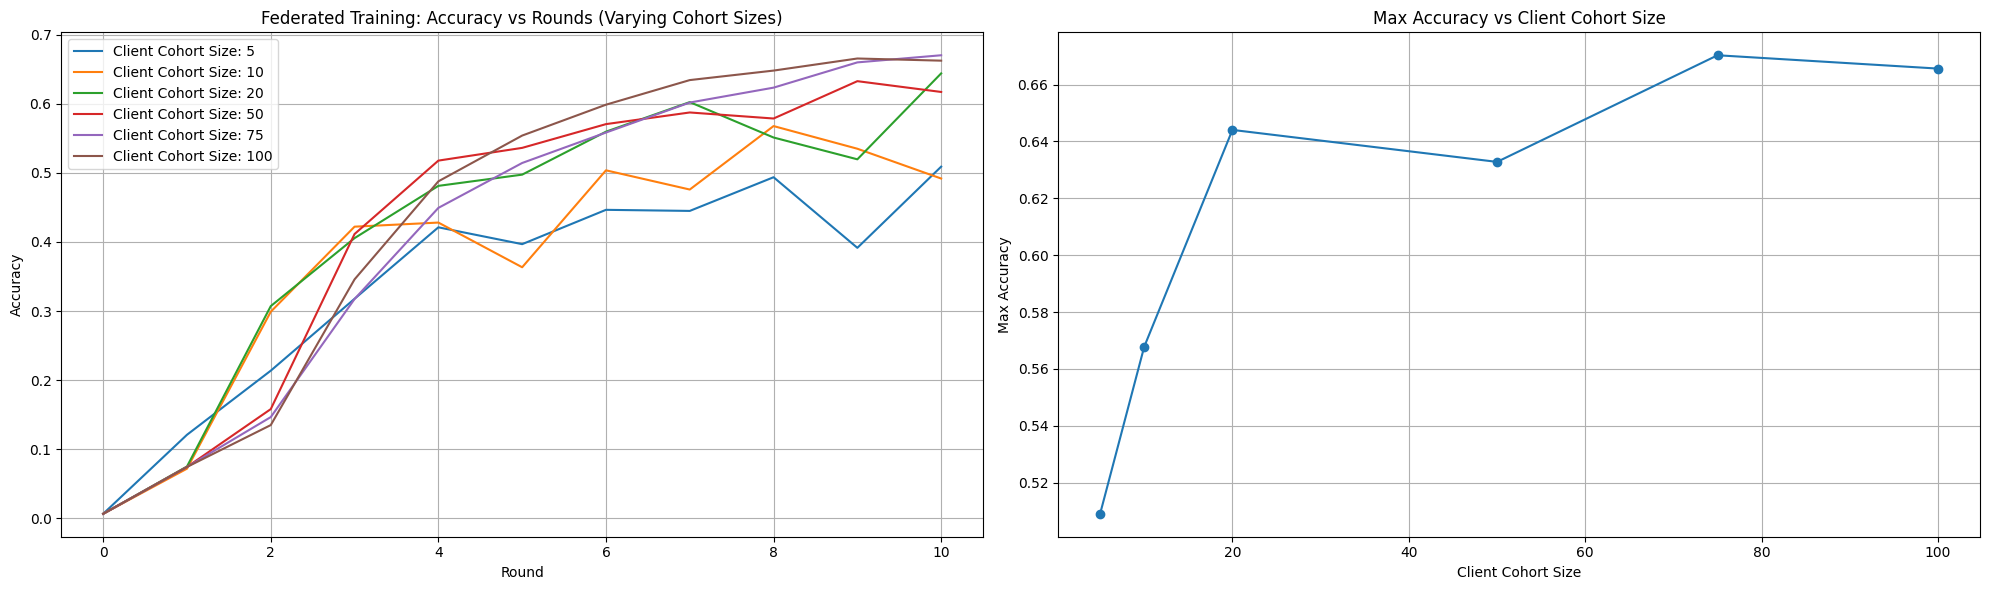

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Left subplot: Accuracy vs Rounds for each client cohort size
for cohort_size, params, hist in total_cohort_results:
    accuracies = get_centralized_acc_from_hist(hist)
    axes[0].plot(accuracies, label=f"Client Cohort Size: {cohort_size}")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Federated Training: Accuracy vs Rounds (Varying Cohort Sizes)")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Max Accuracy vs Client Cohort Size
cohort_sizes = []
max_accuracies = []
for cohort_size, params, hist in total_cohort_results:
    accuracies = get_centralized_acc_from_hist(hist)
    if accuracies:
        cohort_sizes.append(cohort_size)
        max_accuracies.append(max(accuracies))
axes[1].plot(cohort_sizes, max_accuracies, marker='o')
axes[1].set_xlabel("Client Cohort Size")
axes[1].set_ylabel("Max Accuracy")
axes[1].set_title("Max Accuracy vs Client Cohort Size")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bottom-left: Compute Budget vs Training Time
for cohort_size, params, hist in total_cohort_results:
    times = []
    samples = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['training_time']:
        round_times = [t for _, t in round_metrics['all']]
        times.append(np.mean(round_times))
        
    for round_idx, round_metrics in hist.metrics_distributed_fit['samples_processed']:
        round_samples = [s for _, s in round_metrics['all']]
        samples.append(np.sum(round_samples))
    
    cumulative_time = np.sum(times)
    total_samples = np.sum(samples)
    axes[0].plot(cumulative_time, total_samples, marker='o', label=f"Local batch size: {cohort_size}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Bottom-right: Noise Scale Analysis
for cohort_size, params, hist in total_cohort_results:
    noise_scales = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['noise_scale']:
        round_noise_scales = [ns for _, ns in round_metrics['all']]
        noise_scale = np.mean(round_noise_scales)
        noise_scales.append(noise_scale)
    
    avg_noise_scale = np.mean(noise_scales)
    x_axis = cohort_size / (avg_noise_scale + 1e-10)
    y_axis = 1 / (1 + (avg_noise_scale / cohort_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Batch size: {cohort_size}")

axes[1].set_xlabel("Batch Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

When running experiment with varying client cohort sizes, we also observe that such thing as "ideal" client cohort number exists.

However, we have to investigate how to compute it.

**$\beta_\text{simple}$ integration into Federated Learning runs**


To implement the actual $\beta_\text{simple}$ ($\beta_\text{simple} \approx \beta_\text{crit}$) computation, we would need to change the client fit fn to return the gradients after training, and we would need to aggregate them in the server somehow.

In summary, we need to somehow get them to the hist or params object, and figure out a way to aggregate them.

This appears to give us a good estimate of the critical batch size. According to this estimates, the ideal batch size appears to be somewhere in the 16-64, and the optimal batch size we observe is actually 32, which is right in the middle of the range.

In [18]:
for cohort_size, params, hist in total_cohort_results:
    print("Cohort size: ", cohort_size)

    noise_scales = hist.metrics_distributed_fit['noise_scale']

    crit_batches = []
    for round, round_noise_scales in noise_scales:
        actual_noise_scales = [val for _, val in round_noise_scales['all']]
        crit_batch = compute_critical_batch(actual_noise_scales, .001)
        print("---", crit_batch)
        crit_batches.append(crit_batch)
    print(np.mean(crit_batches))       

Cohort size:  5
--- 7.80248109862773
--- 28.80863154453864
--- 39.44193792675061
--- 16.418522119491858
--- 23.587885257923954
--- 46.472020642722576
--- 40.36285129890818
--- 16.44736823714386
--- 31.703064266412596
--- 38.277821331084915
28.93225837236049
Cohort size:  10
--- 12.29627542722681
--- 37.292521723515044
--- 46.193840839889326
--- 46.5115799598944
--- 31.29319776640928
--- 29.693836110458605
--- 18.959104859880682
--- 17.364952357578915
--- 40.91810530871224
--- 24.80715343677625
30.533056779034162
Cohort size:  20
--- 19.739722384542738
--- 31.0173344759884
--- 61.60996143271221
--- 48.52486369235747
--- 42.70039113517227
--- 31.151749182291713
--- 23.104816825037688
--- 23.82753461729023
--- 24.241404597993846
--- 12.684978400571588
31.860275674395815
Cohort size:  50
--- 12.999255957051911
--- 26.08684070515001
--- 39.907745828544066
--- 38.793126851215376
--- 27.155395083408507
--- 26.436905285248503
--- 18.973436183056613
--- 16.92460797405611
--- 18.258250239373034
